<a href="https://colab.research.google.com/github/maciejskorski/new_pll_trng/blob/main/TRNG_Dependency_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilities

Run to install required software and prepare auxiliary functions. 

In [2]:
# update Python lib - and restart the kernel when necessary
!pip install --upgrade statsmodels --quiet
!pip install --upgrade seaborn --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.7 MB/s eta 0:

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from pathlib import Path
import re

from IPython.display import display

import multiprocessing as mp

import logging
import mlflow
from pyngrok import ngrok
from getpass import getpass

plt.rcParams['figure.figsize'] = (10,3)
logger = logging.getLogger('TRNG Analysis')
logger.setLevel(logging.INFO)


def read_dff_v0(filename, KM, KD):
  """ Read dff bits from the raw file. Return a matrix of shape (n_cycles, KD)  """
  raw_data = np.fromfile(filename, dtype="uint8")
  
  # read data choosing the order
  bin_data = np.unpackbits(raw_data, axis=None, count=None, bitorder='little')
  bin_data[0:32]=bin_data[31::-1]
  for i in range(len(bin_data)//32):
      if i>0:
          bin_data[(i*32):((i+1)*32)]=bin_data[((i+1)*32)-1:(i*32)-1:-1]
  #np.savetxt("bin_data.csv", bin_data, delimiter="\t")
  
  # cut Tq periods according to KD
  if len(bin_data)%KD>0:
      bin_data=np.resize(bin_data,(len(bin_data)//KD)*KD) ;# cut last Tq if not full
  img = np.reshape(bin_data,((len(bin_data)//KD),KD)) # (N_CYCLES, KD)
  return img

def read_dff(filename, KM, KD):
  """ Read dff bits from the raw file. Return a matrix of shape (n_cycles, KD)  """
  bytes_data = np.fromfile(filename, dtype="uint8") # read bytes
  bits_data = np.unpackbits(bytes_data, axis=None, count=None, bitorder='little') # unpack to bits
  bits_data = bits_data.reshape((-1,32))[:,::-1].ravel() # reverse bits order in blocks of 32
  bits_data = np.resize(bits_data,(len(bits_data)//KD,KD)) # reshape to cycles
  return bits_data


def get_bytes_data(fpath):
  with open(fpath,'rb') as f:
    bytes_data = f.read()
  bytes_data = pd.DataFrame(list(bytes_data),columns=['byte value'])
  bytes_data.index.name = 'timestep'
  return bytes_data


def get_metadata(fpath):
  """ Read mean and alan variance, as stored in log* files """
  with open(fpath,'r') as f:
    metadata = f.read()
    rgx_mean = re.compile('\nMean:\s+(\d+.\d+)')
    rgx_alan = re.compile('\nAllan variance:\s+(\d+.\d+)')
    mean = float(rgx_mean.search(metadata).group(1))
    var_alan = float(rgx_alan.search(metadata).group(1))
    return mean,var_alan


def counter_val(x):
  return x


def last_bit(x):
  return x % 2


def diff_last_bit(x):
  return x.diff().loc[1:] % 2


def analyze_series(bytes_data, nlags=10, alpha=0.05, postprocess_fn=last_bit):
  """ Analyze dependencies of TRNG bytes candidate.
      Args:
          bytes_data (pandas.DataFrame): series of raw bytes (das), encoded as integers uint8
          nlags (int): maximum number of lags to analyse
          alpha (float): confidence level for hypothesis testing
          postprocess_fn (function): transform applied to the series. For example, use <mod 2> to extract the last significant bit
      Return:
          figure: picture with plots
  """
  params = {
        'lags':nlags,
        'alpha':alpha,
        'postprocess_fn':postprocess_fn.__name__
  }
  mlflow.log_params(params)
  fig,axs = plt.subplots(1,2,constrained_layout=True)
  # plot histogram
  ax = axs[0]
  sns.histplot(data=bytes_data,x='byte value',ax=ax,discrete=True)
  # plot time series
  ax = axs[1]
  sns.lineplot(data=bytes_data.loc[:1000],x='timestep',y='byte value',ax=ax)
  plt.show()
  mlflow.log_figure(fig,'exploratory.png')
  bytes_data = postprocess_fn(bytes_data)
  # descriptive stats
  if postprocess_fn==counter_val:
    mlflow.log_metric('mean',bytes_data.mean())
  # stationarity tests on postprocessed data
  results = kpss(bytes_data,nlags=10)
  pval = results[1]
  mlflow.log_metric(f'stationary.KPSS.lag_{nlags}',pval)
  results = adfuller(bytes_data,maxlag=10)
  pval = results[1]
  mlflow.log_metric(f'not-stationary.ADF.lag_{nlags}',pval)
  # plot autocorelation by 
  fig,ax = plt.subplots(1,1,constrained_layout=True)
  fig = plot_acf(x=bytes_data, lags = nlags, fft=True, alpha=alpha, bartlett_confint=True, zero=False, adjusted=True, ax=ax, auto_ylims=True)
  ax.set(xlabel='Lag',ylabel='Corr')
  plt.show()
  mlflow.log_figure(fig,'autocorrelation.png')
  # find p-values for autocorrelation
  _,_,_,pvals = acf(
          x=bytes_data,
          nlags=nlags,
          alpha=alpha,
          fft=True,
          bartlett_confint=True,
          adjusted=True,
          qstat=True
  )
  pvals = {'lag':np.arange(1,nlags+1),'Ljung-Box Test p-val':pvals}
  pvals = pd.DataFrame(data=pvals)
  pvals.set_index('lag',inplace=True)
  display(pvals)
  mlflow.log_metric(f'not-correlated.LjungBox.lag_{nlags}',pvals.loc[nlags])

# Logging

Result outcmes are tracked with `mlflow`, and interactively presented under the temporary domain set up with `ngrok`.

In [67]:
# run mlflow server
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
#NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')  
NGROK_AUTH_TOKEN = '2FSPi7SWydYp4hJlGzr3XDDT2qZ_2nRDVc628Fc4he4znxSSV'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True,
                             #auth="SaintEtienne:TCHES"
                             )

mlflow.set_tracking_uri(ngrok_tunnel.public_url)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://90fb-34-86-251-236.ngrok.io


# Analysis of 2023-01-09 data 

## Download Data

In [4]:
!curl -L "https://filesender.renater.fr/download.php?token=3bde9aca-9e6e-41df-935e-bce8ea902b09&files_ids=20766730" --output TCHES2023_0109.zip
!unzip -q TCHES2023_0109.zip -d TCHES2023_0109/ # all configs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6774k  100 6774k    0     0   401k      0  0:00:16  0:00:16 --:--:--  466k


In [19]:
!curl -L "https://filesender.renater.fr/download.php?token=a6a8e94b-d88f-4fae-8800-7d727344c5ec&files_ids=20824359" --output Viktor_0110.zip
!unzip -q Viktor_0110.zip -d Viktor_0110/
!curl -L "https://filesender.renater.fr/download.php?token=bff3eec2-4aea-4008-b442-8f6e99a80658&files_ids=20833133" --output Viktor_0110.zip
!unzip -q Viktor_0110.zip -d Viktor_0110/ 
!mv Viktor_0110/CV_M1_C1_regional Viktor_0110/Card_M1
!mv Viktor_0110/CV_M1_C2_regional Viktor_0110/Card_M1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30.2M  100 30.2M    0     0   778k      0  0:00:39  0:00:39 --:--:--  791k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5945k  100 5945k    0     0   735k      0  0:00:08  0:00:08 --:--:--  797k


## Jobs

[ExpConfig(name='CV_M2_B2_regional', inputfile=PosixPath('/content/Viktor_0110/Card_M2/CV_M2_B2_regional/acq_20230105201113_dff_km468_kd475.bin'), KM=468, KD=475, card=2, experiment='CV_B2', params={'bit_pdf': True, 'bits_intra_correlation': True}), ExpConfig(name='CV_M2_B1_regional', inputfile=PosixPath('/content/Viktor_0110/Card_M2/CV_M2_B1_regional/acq_20230105195950_dff_km468_kd475.bin'), KM=468, KD=475, card=2, experiment='CV_B1', params={'bit_pdf': True, 'bits_intra_correlation': True}), ExpConfig(name='CV_M2_A1_regional', inputfile=PosixPath('/content/Viktor_0110/Card_M2/CV_M2_A1_regional/acq_20230105183423_dff_km728_kd435.bin'), KM=728, KD=435, card=2, experiment='CV_A1', params={'bit_pdf': True, 'bits_intra_correlation': True}), ExpConfig(name='CV_M2_C1_regional', inputfile=PosixPath('/content/Viktor_0110/Card_M2/CV_M2_C1_regional/acq_20230109170431_dff_km200_kd183.bin'), KM=200, KD=183, card=2, experiment='CV_C1', params={'bit_pdf': True, 'bits_intra_correlation': True}), Exp

INFO:TRNG Analysis:Doing experiment CV_M2_B2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M2_B1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M2_A1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
INFO:TRNG Analysis:Doing experiment CV_M2_C1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in

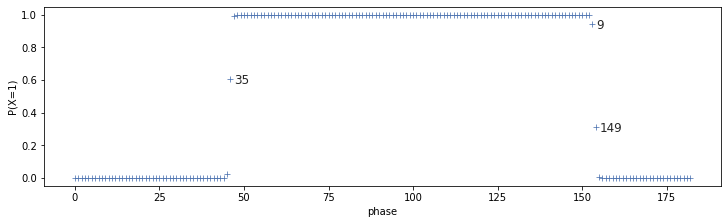

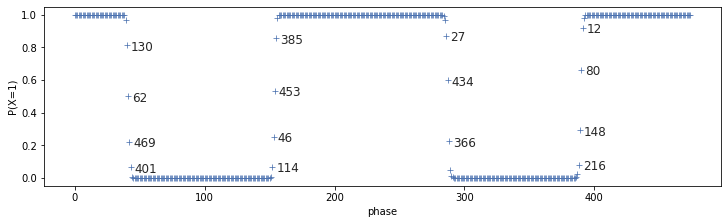

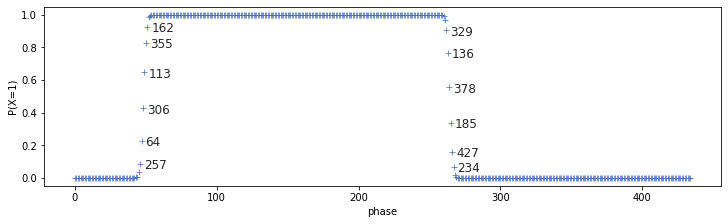

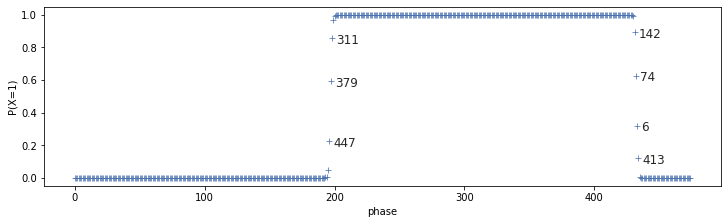

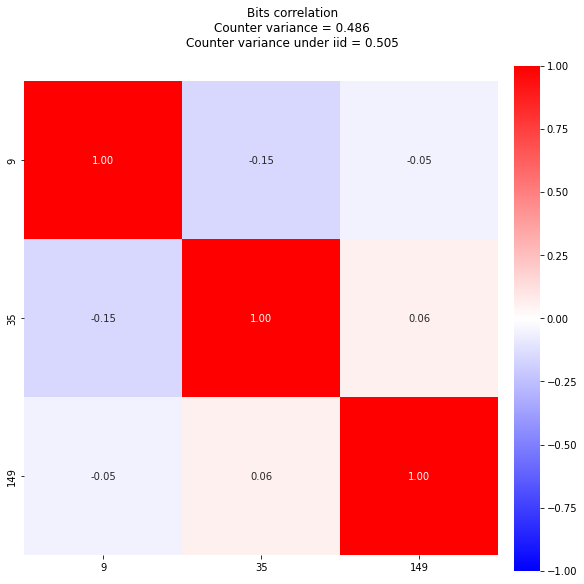

INFO:TRNG Analysis:Doing experiment CV_M2_C2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


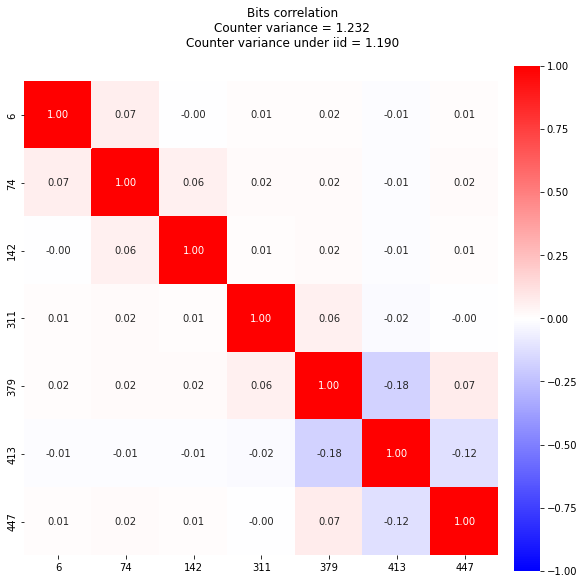

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


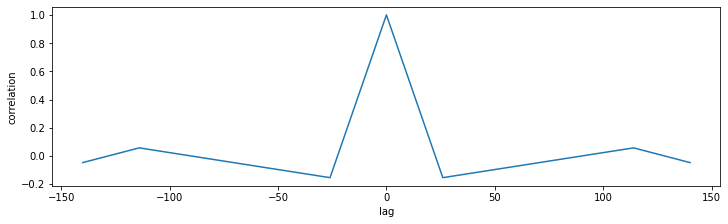

INFO:TRNG Analysis:Doing experiment CV_M2_A2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}


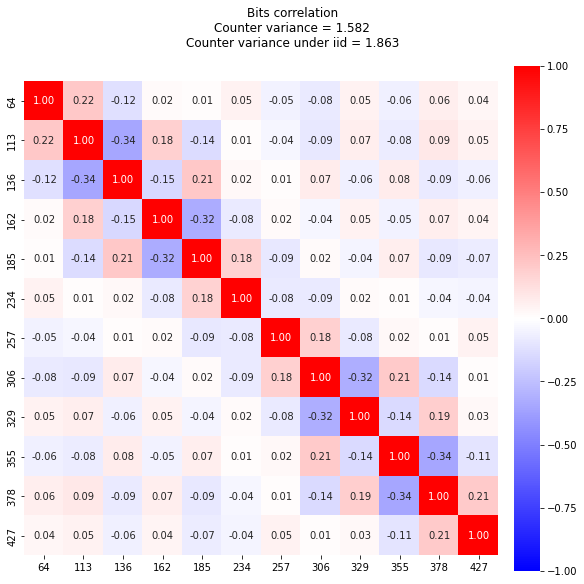

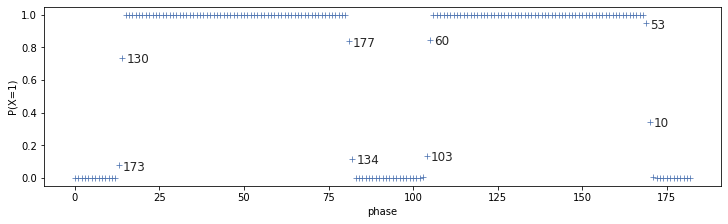

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG Analysis:Doing experiment CV_M1_C1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}


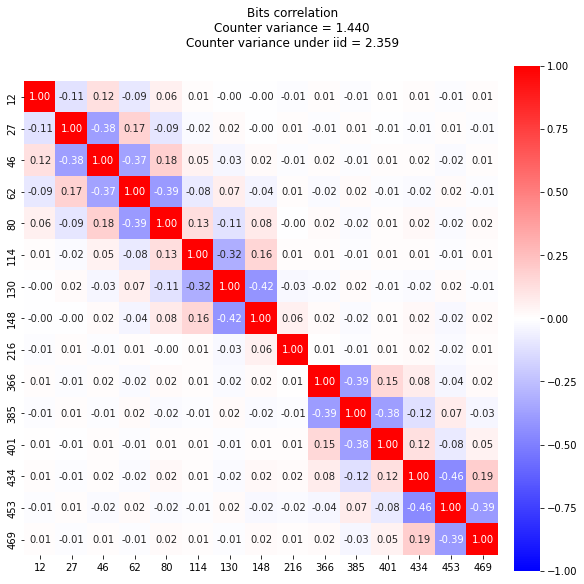

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


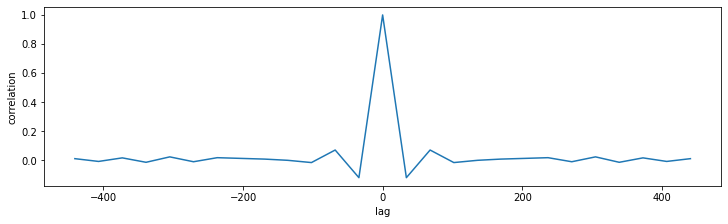

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


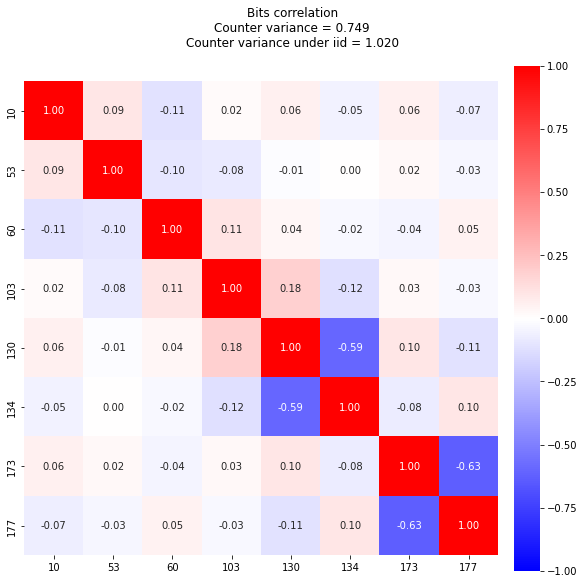

INFO:TRNG Analysis:Doing experiment CV_M1_A2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


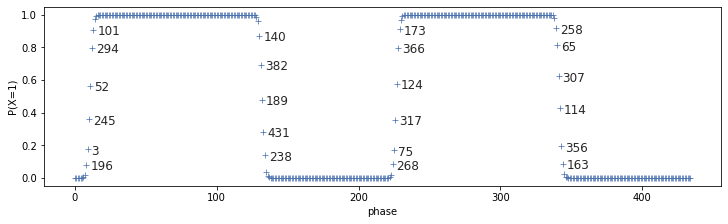

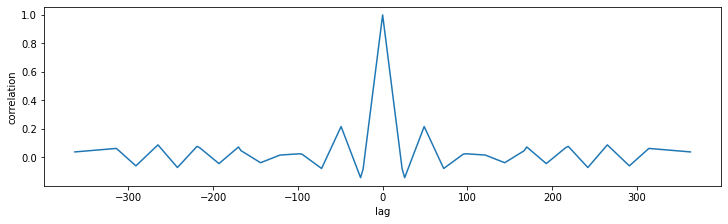

INFO:TRNG Analysis:Doing experiment CV_M1_A1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


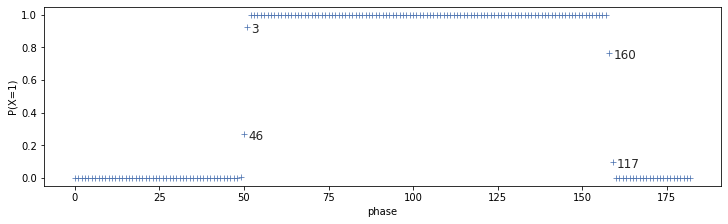

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


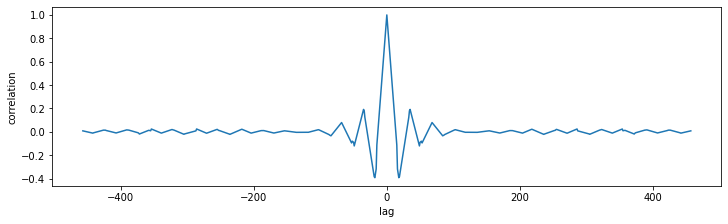

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


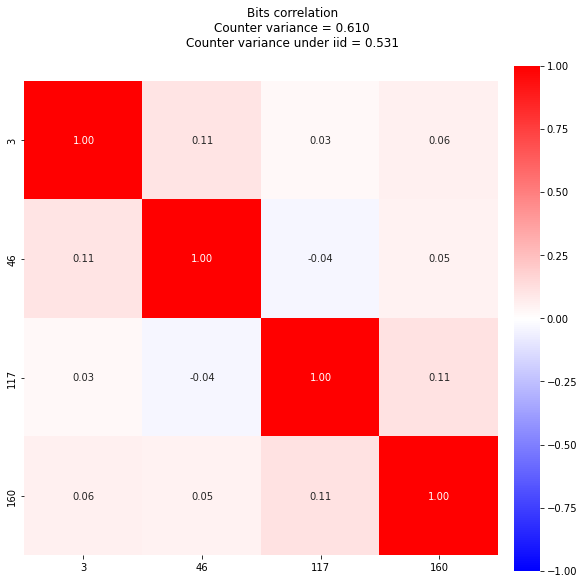

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


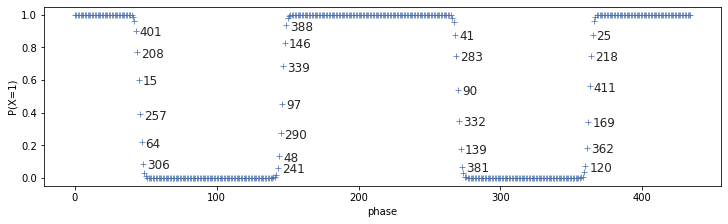

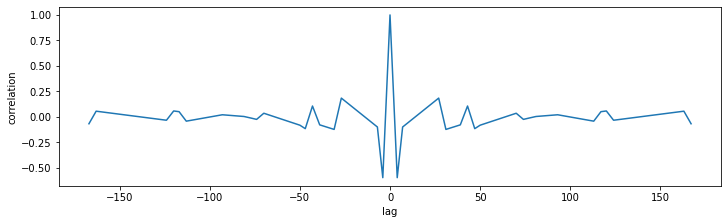

INFO:TRNG Analysis:Doing experiment CV_M1_B1_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}


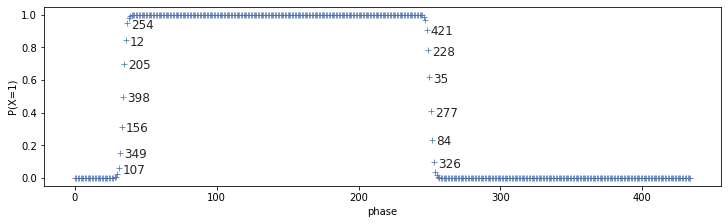

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


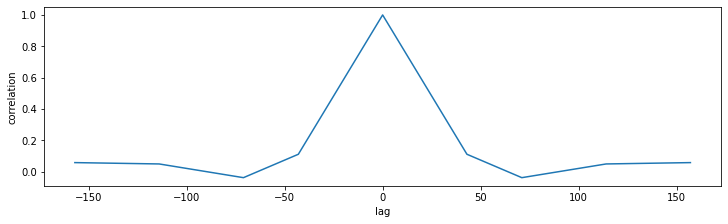

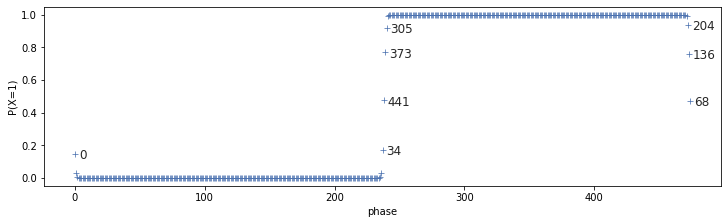

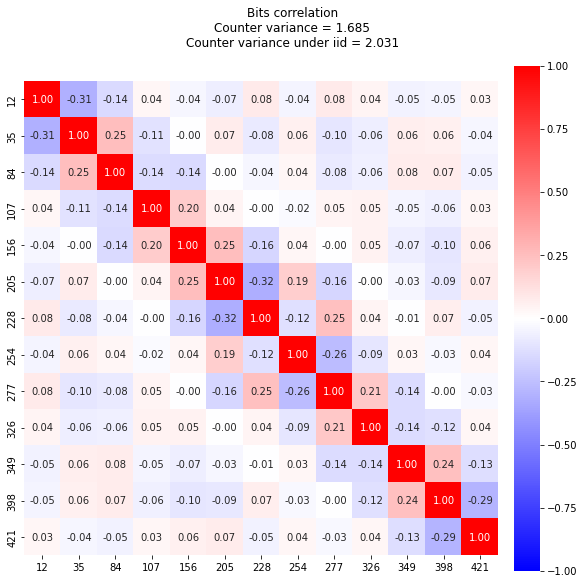

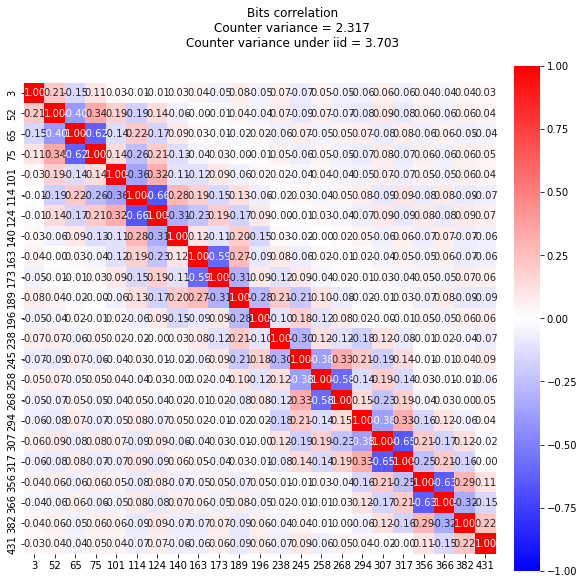

INFO:TRNG Analysis:Doing experiment CV_M1_B2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}


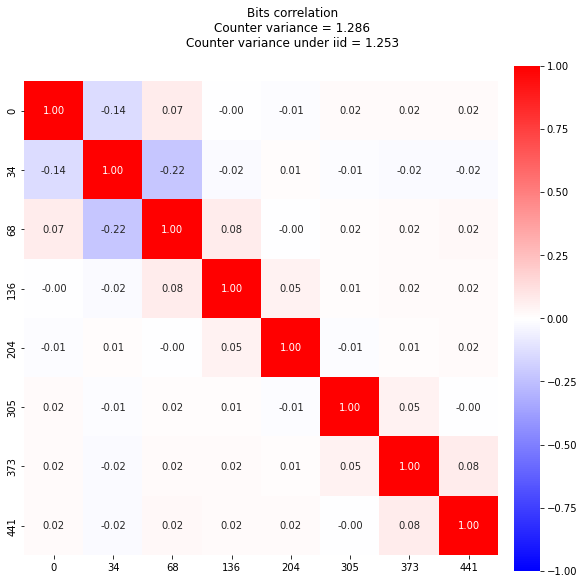

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
INFO:TRNG Analysis:Doing experiment CV_M1_C2_regional with params {'bit_pdf': True, 'bits_intra_correlation': True}
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


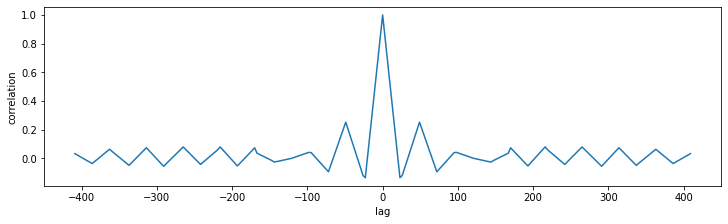

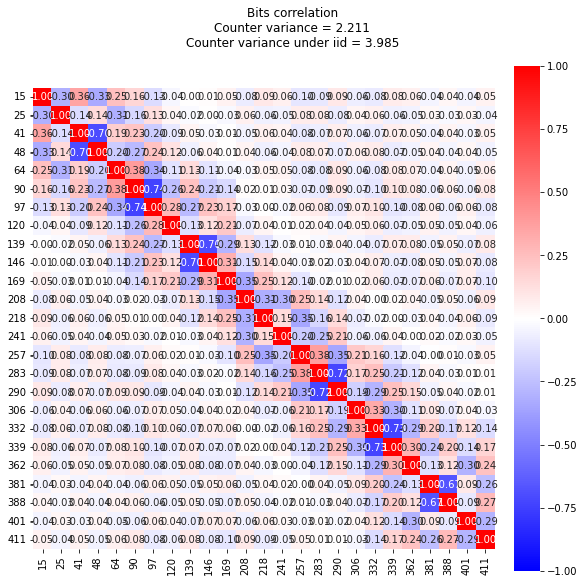

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


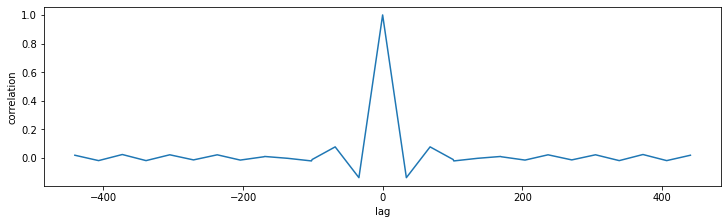

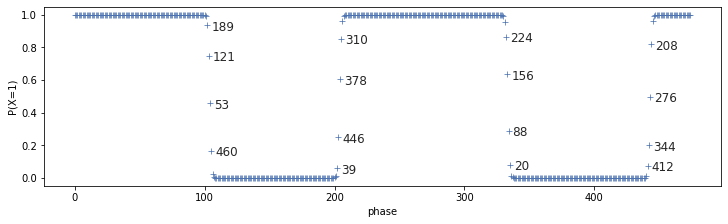

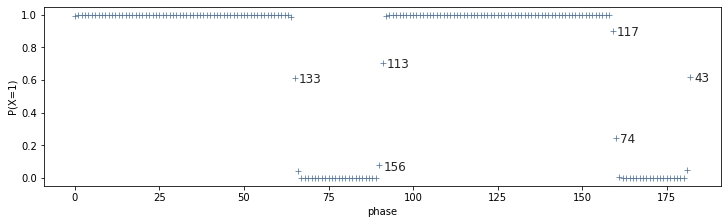

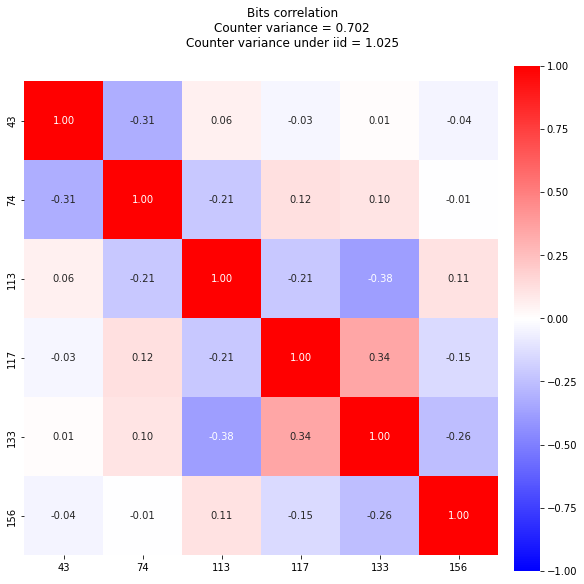

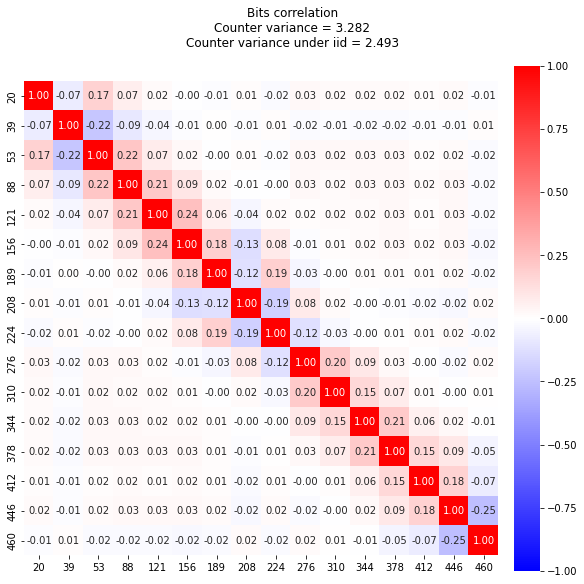

In [68]:
from collections import namedtuple

ExpConfig = namedtuple('ExpConfig','name inputfile KM KD card experiment params')

def generate_configs(root_path):
  for fname in Path(root_path).glob('*/*/*.bin'):
    if 'bit.bin' not in fname.name:
      cfg_name = fname.parent.name
      km_kd_pattern = re.compile('km(\d+)_kd(\d+)')
      KM,KD = map(int,km_kd_pattern.search(str(fname)).groups())
      card_pattern = re.compile('Card_M(\d)')
      card = int(card_pattern.search(str(fname)).groups()[0])
      experiment_pattern = re.compile('(\w+)_M\d_(\w\d)')
      experiment = '_'.join(experiment_pattern.search(str(fname)).groups())
      yield ExpConfig(name=cfg_name,inputfile=fname,
                      KM=KM,
                      KD=KD,
                      card=card,
                      experiment=experiment,
                      params = {'bit_pdf':True,'bits_intra_correlation':True}
                    )


def get_config_result(cfg):
  """ Job """
  logger.info(f'Doing experiment {cfg.name} with params {cfg.params}' )
  with mlflow.start_run(run_name=cfg.inputfile.parent.name):
    mlflow.log_param('file',cfg.inputfile)
    mlflow.log_param('KM',cfg.KM)
    mlflow.log_param('KD',cfg.KD)
    mlflow.log_param('card',cfg.card)
    mlflow.log_param('experiment',cfg.experiment)
    KM = cfg.KM
    KD = cfg.KD
    bits = read_dff(cfg.inputfile,KM=KM,KD=KD)
    if cfg.params.get('bit_pdf'):
      ps = bits.mean(0)
      idx = np.arange(KD)*KM%KD
      fig,ax = plt.subplots(constrained_layout=True)
      df = pd.DataFrame(zip(idx,ps),columns=['phase','P(X=1)'])
      mask = (df['P(X=1)']>=0.05) & (df['P(X=1)']<=0.95)
      df.loc[mask,'text'] = df.index[mask].astype('Int32')
      df['text'].fillna('',inplace=True)
      p = so.Plot(df,x='phase',y='P(X=1)',text='text').add(so.Dot(marker='+')).add(so.Text(halign='left'))
      p.on(ax).show()
      mlflow.log_figure(fig,'probability_density.svg')
    if cfg.params.get('bits_intra_correlation'):
      fig,ax = plt.subplots(figsize=(8,8),constrained_layout=True)
      good_idx =np.arange(KD)[(ps > 0.05) & (ps < 0.95)]
      good_bits = bits[:,good_idx]
      corr_matrix = np.corrcoef(good_bits.T)
      var_emp = good_bits.sum(1).var()
      mlflow.log_metric('variance_empirical',var_emp)
      ps = good_bits.mean(0)
      var_iid = np.sum(ps*(1-ps))
      mlflow.log_metric('variance_model_iid',var_iid)
      sns.heatmap(corr_matrix,cmap='bwr',
                  vmin=-1,vmax=1,
                  xticklabels=good_idx,yticklabels=good_idx,
                  square=True,annot=True,fmt=".2f",
                  ax=ax)
      plt.suptitle(f'Bits correlation\nCounter variance = {var_emp:.3f}\nCounter variance under iid = {var_iid:.3f}')
      plt.show()
      mlflow.log_figure(fig,'bits_intra_correlation.svg')

      fig,ax = plt.subplots(constrained_layout=True)
      distances = good_idx.reshape(-1,1)-good_idx.reshape(1,-1)
      lagged_corr = pd.DataFrame(data=zip(distances.ravel(),corr_matrix.ravel()),columns=['lag','correlation'])
      lagged_corr = lagged_corr.groupby('lag').max()
      sns.lineplot(data=lagged_corr,x='lag',y='correlation',ax=ax)
      mlflow.log_figure(fig,'bits_auto_correlation.svg')


cfgs = list( generate_configs('/content/Viktor_0110') )
print(cfgs)
with mp.Pool(4) as p:
  p.map(get_config_result,cfgs)

## Others

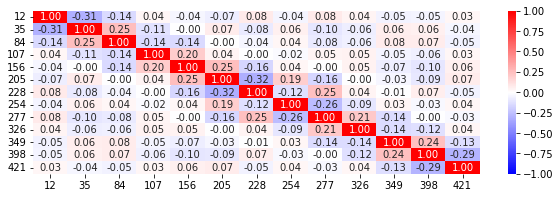

In [38]:
fname = "/content/Viktor_0110/Card_M1/CV_M1_A1_regional/acq_20230107112901_dff_km728_kd435.bin"
KM=728
KD=435
bits = read_dff(fname,KM=KM,KD=KD)

good_idx =np.arange(KD)[(ps > 0.05) & (ps < 0.95)]
good_bits = bits[:,good_idx]
corr_matrix = np.corrcoef(good_bits.T)

sns.heatmap(corr_matrix,cmap='bwr',
              vmin=-1,vmax=1,
              xticklabels=good_idx,yticklabels=good_idx,
              square=False,annot=True,fmt=".2f",
              )

# Analysis of September Data

## Analyze

INFO:TRNG Analysis:Doing experiment CV_a2_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}
INFO:TRNG Analysis:Doing experiment CV_c2_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}
INFO:TRNG Analysis:Doing experiment CV_a1_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}
INFO:TRNG Analysis:Doing experiment CV_b1_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}


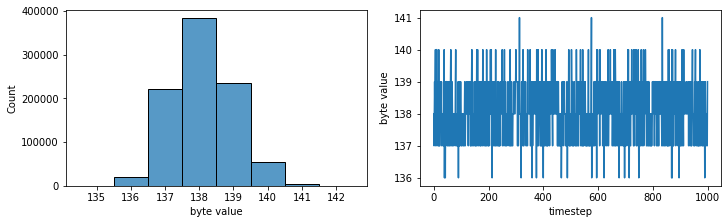

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


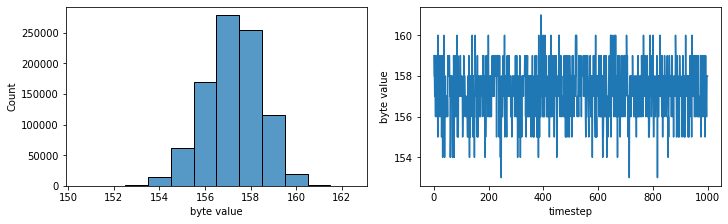

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


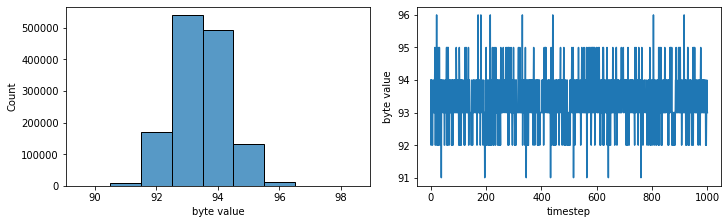

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


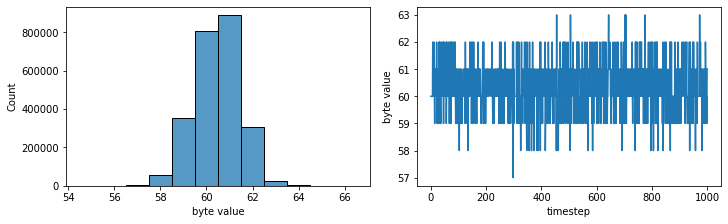

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


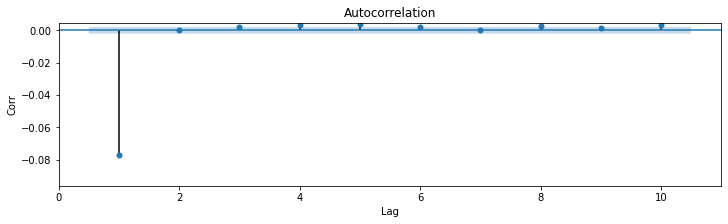

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment CV_a1_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


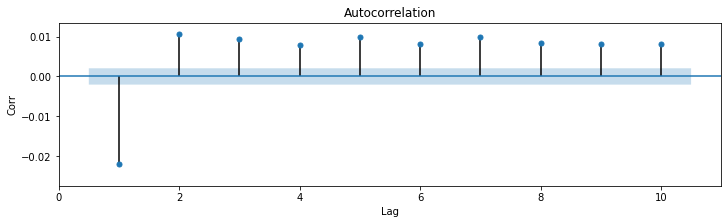

,Ljung-Box Test p-val
lag,
1,4.801803e-98
2,1.042757e-119
3,2.063617e-136
4,2.662691e-147
5,4.125994e-165
6,9.447499e-177
7,1.409467e-194
8,1.533446e-207
9,6.750065e-220


INFO:TRNG Analysis:Doing experiment CV_a2_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


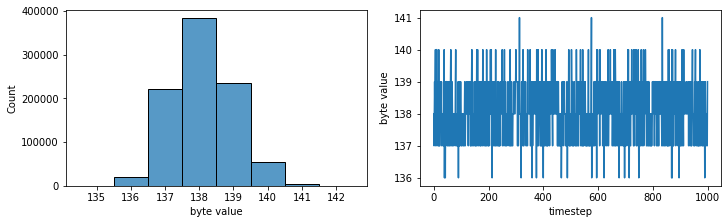

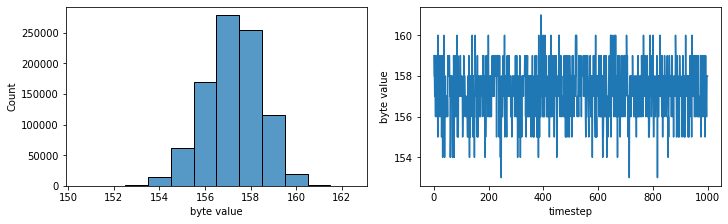

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


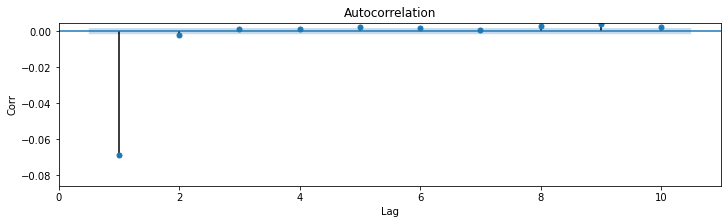

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment CV_b1_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


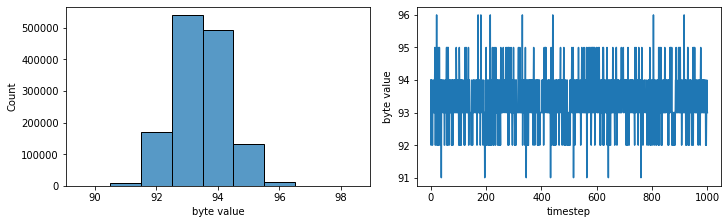

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


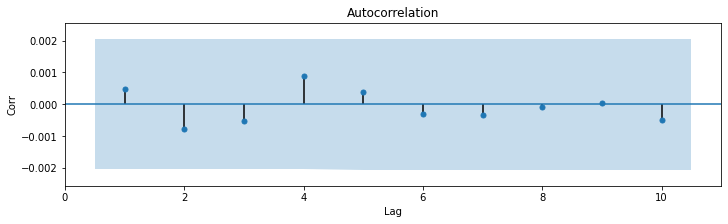

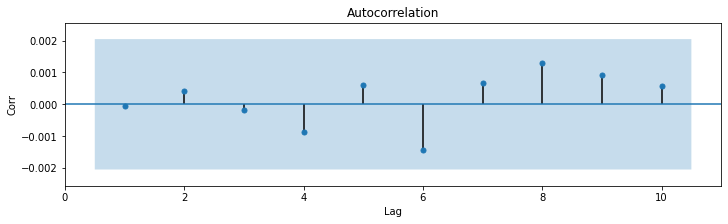

,Ljung-Box Test p-val
lag,
1,0.635150
2,0.676543
3,0.791446
4,0.781393
5,0.863335
6,0.921588
7,0.954820
8,0.978029
9,0.989869


INFO:TRNG Analysis:Doing experiment CV_b2_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}


,Ljung-Box Test p-val
lag,
1,0.954206
2,0.920501
3,0.978103
4,0.923360
5,0.939858
6,0.795609
7,0.835688
8,0.753957
9,0.757851


INFO:TRNG Analysis:Doing experiment CV_a1_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}


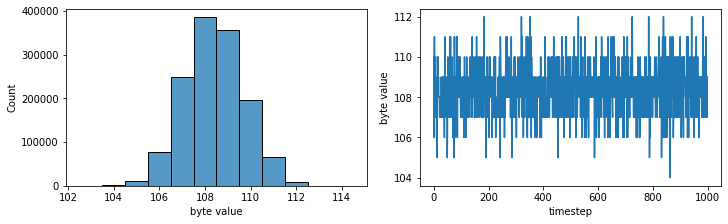

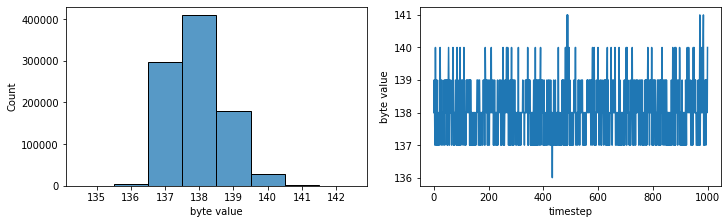

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


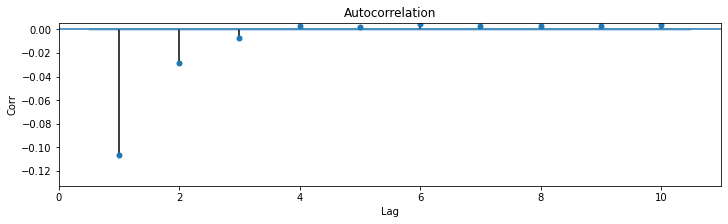

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment CV_c2_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


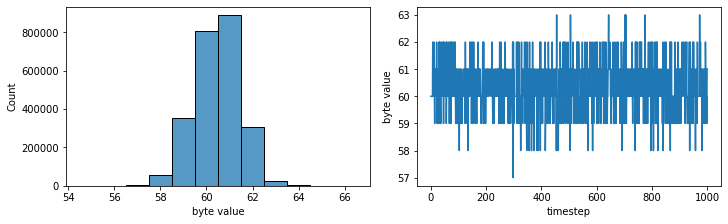

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


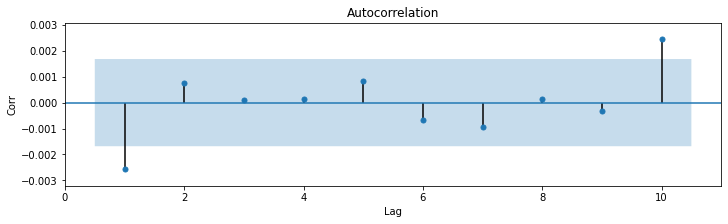

,Ljung-Box Test p-val
lag,
1,0.002775
2,0.007704
3,0.020878
4,0.044390
5,0.057328
6,0.078617
7,0.083665
8,0.126917
9,0.175832


INFO:TRNG Analysis:Doing experiment CV_c1_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}


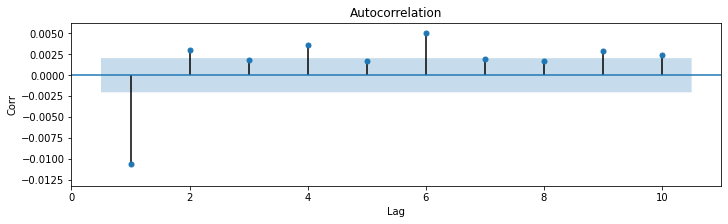

,Ljung-Box Test p-val
lag,
1,3.590544e-24
2,6.014827e-25
3,1.138080e-24
4,2.563471e-26
5,4.517991e-26
6,3.257758e-30
7,3.556993e-30
8,4.575722e-30
9,4.780589e-31


INFO:TRNG Analysis:Doing experiment CV_a1_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


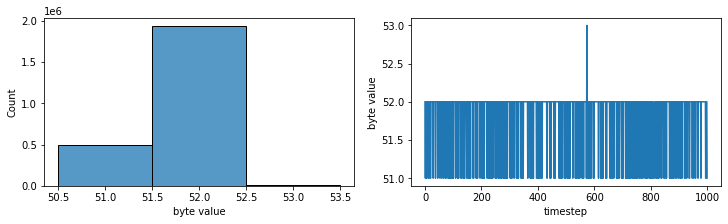

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


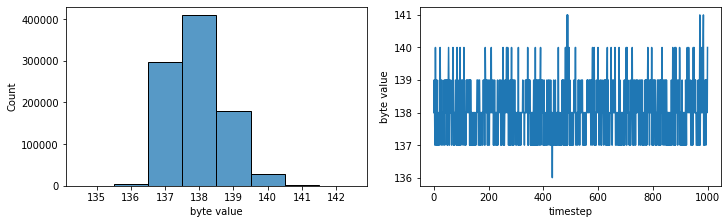

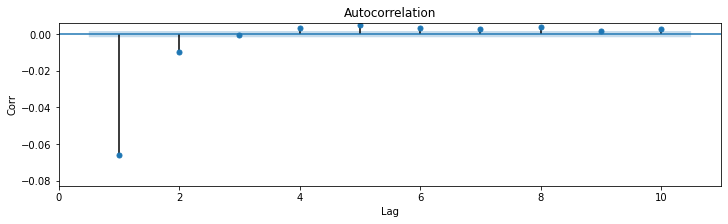

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment CV_b2_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


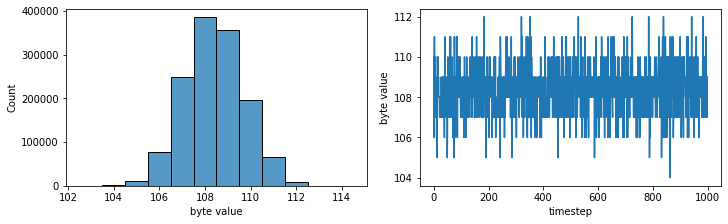

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


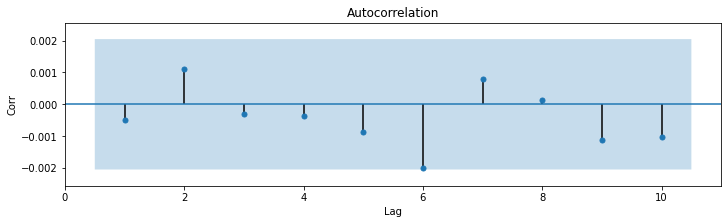

,Ljung-Box Test p-val
lag,
1,0.637050
2,0.515755
3,0.701877
4,0.821232
5,0.816696
6,0.436544
7,0.488971
8,0.596001
9,0.574150


INFO:TRNG Analysis:Doing experiment CV_a2_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}


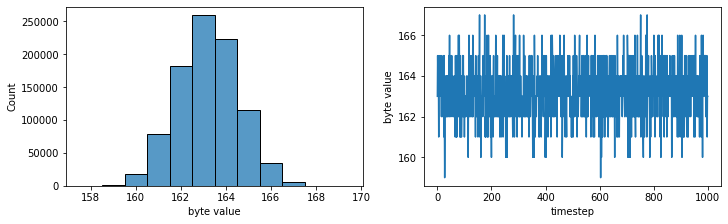

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


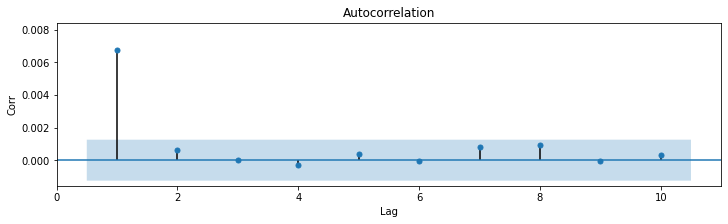

,Ljung-Box Test p-val
lag,
1,7.804132e-26
2,6.517930e-25
3,5.527548e-24
4,3.370428e-23
5,1.616809e-22
6,8.090127e-22
7,1.766923e-21
8,2.729950e-21
9,1.074126e-20


INFO:TRNG Analysis:Doing experiment CV_c1_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}


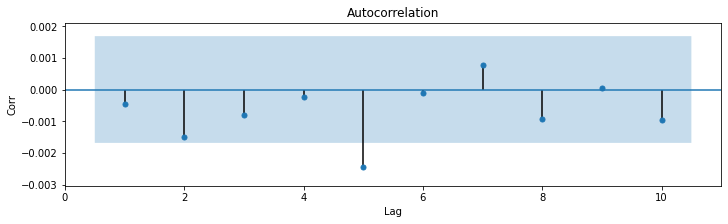

,Ljung-Box Test p-val
lag,
1,0.604014
2,0.195934
3,0.249725
4,0.380432
5,0.032220
6,0.057394
7,0.071374
8,0.076241
9,0.114672


INFO:TRNG Analysis:Doing experiment CV_b1_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}


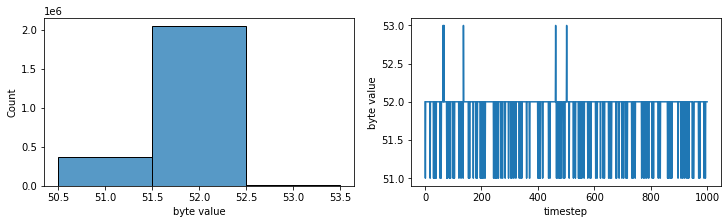

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


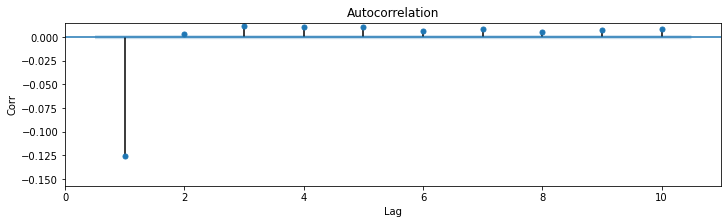

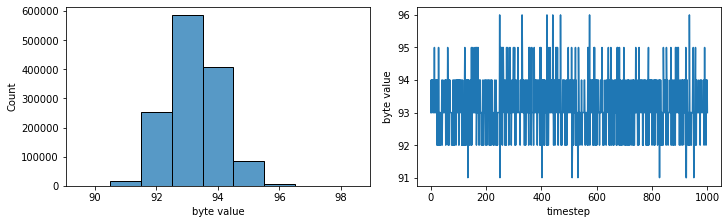

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment CV_a2_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


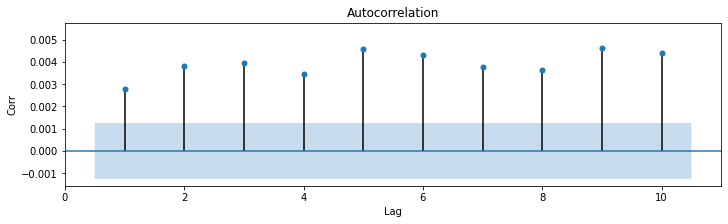

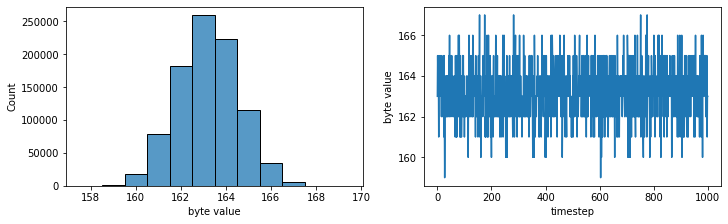

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,Ljung-Box Test p-val
lag,
1,1.331007e-05
2,1.427357e-12
3,6.494155e-20
4,2.304584e-25
5,1.492386e-35
6,1.782207e-44
7,5.597843e-51
8,4.776025e-57
9,3.123875e-67


INFO:TRNG Analysis:Doing experiment CV_c1_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


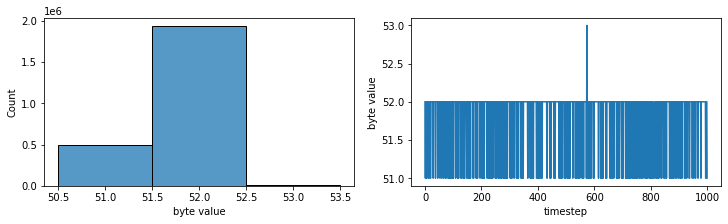

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


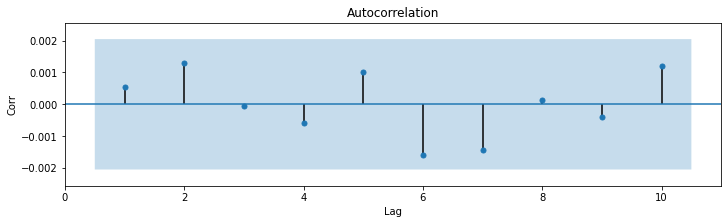

,Ljung-Box Test p-val
lag,
1,0.609532
2,0.401387
3,0.608661
4,0.706220
5,0.684292
6,0.492204
7,0.399333
8,0.503931
9,0.589530


INFO:TRNG Analysis:Doing experiment CV_b2_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}


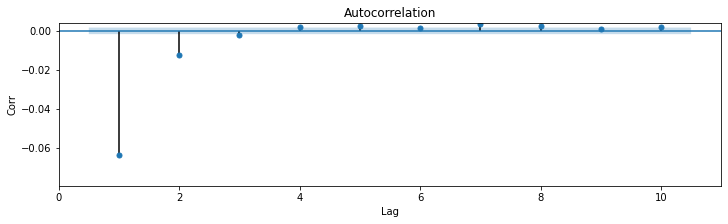

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment CV_b1_M2 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


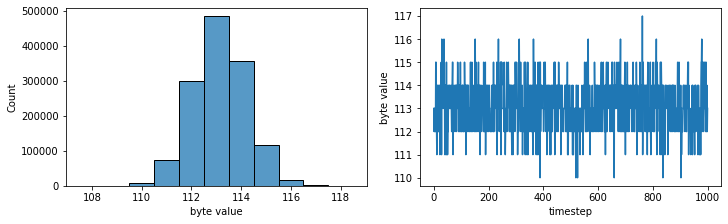

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


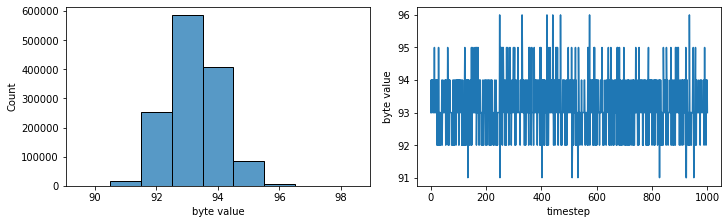

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


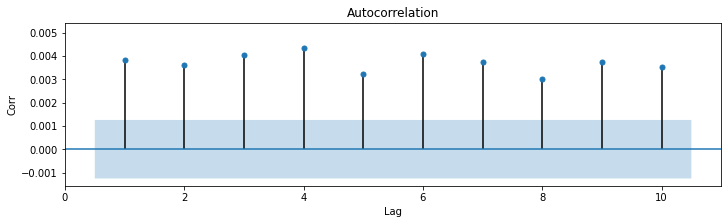

,Ljung-Box Test p-val
lag,
1,2.394577e-09
2,2.678786e-15
3,5.568488e-23
4,5.601110e-32
5,1.663967e-36
6,2.111035e-44
7,8.518627e-51
8,9.943785e-55
9,3.935224e-61


INFO:TRNG Analysis:Doing experiment CV_c1_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


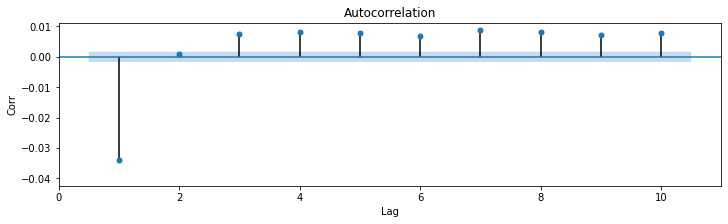

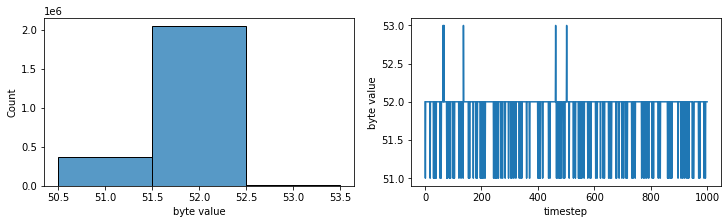

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment CV_b2_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


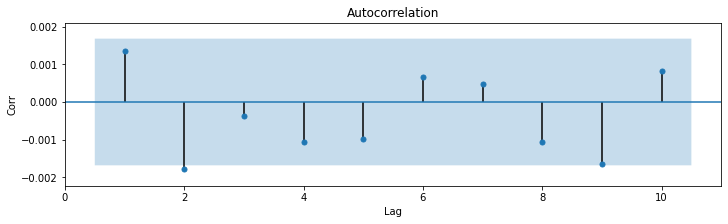

,Ljung-Box Test p-val
lag,
1,0.111698
2,0.032798
3,0.071252
4,0.073064
5,0.079245
6,0.106087
7,0.148406
8,0.137376
9,0.067994


INFO:TRNG Analysis:Doing experiment CV_c2_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7fe009a0a4c0>}


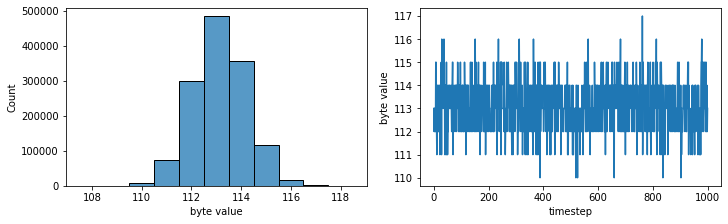

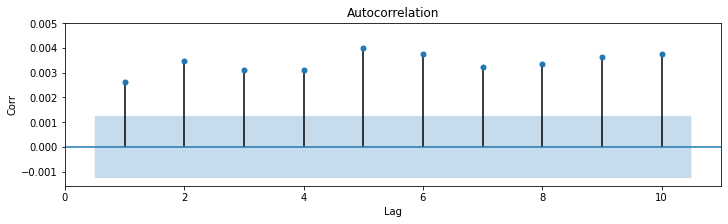

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,Ljung-Box Test p-val
lag,
1,4.338858e-05
2,1.058881e-10
3,6.169141e-15
4,3.750184e-19
5,9.709788e-27
6,3.347202e-33
7,8.569422e-38
8,8.803628e-43
9,8.552872e-49


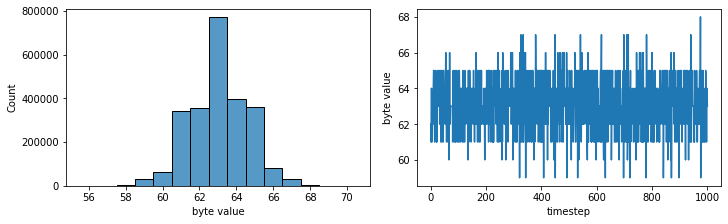

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


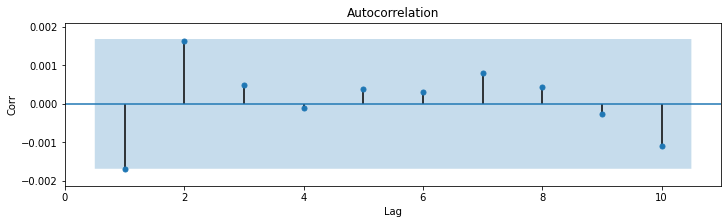

,Ljung-Box Test p-val
lag,
1,0.047797
2,0.023569
3,0.050105
4,0.098099
5,0.154963
6,0.226921
7,0.252295
8,0.319711
9,0.403615


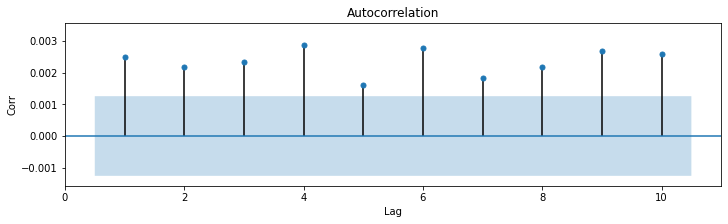

,Ljung-Box Test p-val
lag,
1,1.034643e-04
2,1.813606e-06
3,1.297183e-08
4,3.767721e-12
5,7.927966e-13
6,4.665315e-16
7,3.978403e-17
8,6.930691e-19
9,7.235515e-22


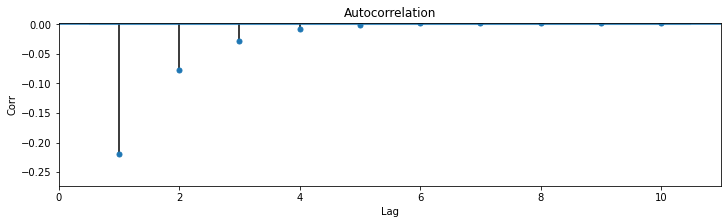

,Ljung-Box Test p-val
lag,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


INFO:TRNG Analysis:Doing experiment CV_c2_M1 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function last_bit at 0x7fe009a0a280>}


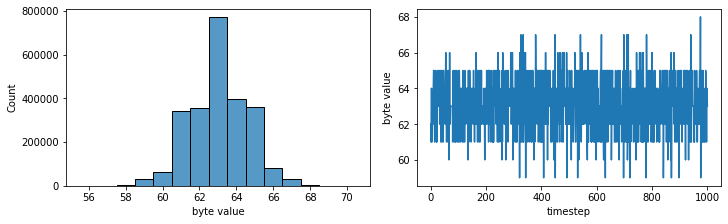

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


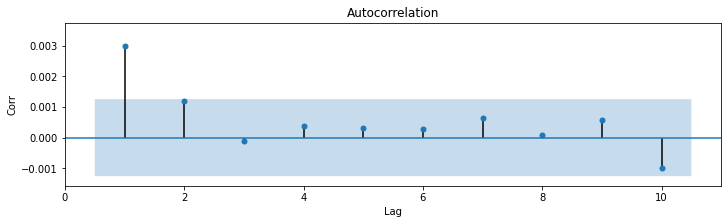

,Ljung-Box Test p-val
lag,
1,0.000003
2,0.000003
3,0.000013
4,0.000035
5,0.000090
6,0.000205
7,0.000310
8,0.000653
9,0.000938


In [ ]:
from collections import namedtuple

ExpConfig = namedtuple('ExpConfig','name inputfile params')

def generate_configs(root_path):
  for fname in Path(root_path).glob('*/*.bin'):
    if 'bit.bin' not in fname.name:
      cfg_name = fname.parent.name
      yield ExpConfig(name=cfg_name,inputfile=fname,
                      params={'alpha':0.05,'nlags':10,'postprocess_fn':counter_val}
                      )
      yield ExpConfig(name=cfg_name,inputfile=fname,
                      params={'alpha':0.05,'nlags':10,'postprocess_fn':last_bit}
                      )

def get_config_result(cfg):
  """ Job """
  logger.info(f'Doing experiment {cfg.name} with params {cfg.params}' )
  with mlflow.start_run(run_name=cfg.inputfile.parent.name):
    metadata_path = next(cfg.inputfile.parent.rglob('*meas.log'))
    mean,var_alan = get_metadata(metadata_path)
    mlflow.log_param('file',cfg.inputfile)
    mlflow.log_metric('mean_logged',mean)
    mlflow.log_metric('var_alan_logged',var_alan)
    km_kd_pattern = re.compile('km(\d+)_kd(\d+)')
    KM,KD = map(int,km_kd_pattern.search(cfg.inputfile.name).groups())
    bytes_data = read_dff(cfg.inputfile,KM,KD).sum(-1)
    bytes_data = pd.DataFrame(list(bytes_data),columns=['byte value'])
    bytes_data.index.name = 'timestep'
    analyze_series(
        bytes_data,
        **cfg.params
    )

cfgs = list( generate_configs('/content/TCHES2023') )
with mp.Pool(4) as p:
  p.map(get_config_result,cfgs)

## Summarize

In [ ]:
!mlflow experiments csv --experiment-id 0 --filename runs.csv
results = pd.read_csv('runs.csv')

keep_cols = ['tags.mlflow.runName','params.postprocess_fn','metrics.not-correlated.LjungBox.lag_10','metrics.stationary.KPSS.lag_10','metrics.not-stationary.ADF.lag_10']
summary = results[keep_cols]\
  .pivot(index='tags.mlflow.runName',columns='params.postprocess_fn')\
  .swaplevel(0,1,axis=1)\
  .sort_index(1)
summary.head()

Experiment with ID 0 has been exported as a CSV to file: runs.csv.


<ipython-input-125-289b239910c6>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  summary = results[keep_cols]\


params.postprocess_fn                            counter_val  \
                      metrics.not-correlated.LjungBox.lag_10   
tags.mlflow.runName                                            
CV_a1_M1                                        0.000000e+00   
CV_a1_M2                                        1.673354e-31   
CV_a2_M1                                        0.000000e+00   
CV_a2_M2                                       9.005646e-232   
CV_b1_M1                                        0.000000e+00   

params.postprocess_fn                                    \
                      metrics.not-stationary.ADF.lag_10   
tags.mlflow.runName                                       
CV_a1_M1                                            0.0   
CV_a1_M2                                            0.0   
CV_a2_M1                                            0.0   
CV_a2_M2                                            0.0   
CV_b1_M1                                            0.0   

params.postprocess_fn                                 \
                      metrics.stationary.KPSS.lag_10   
tags.mlflow.runName                                    
CV_a1_M1                                        0.01   
CV_a1_M2                                        0.01   
CV_a2_M1                                        0.01   
CV_a2_M2                                        0.01   
CV_b1_M1                                        0.01   

params.postprocess_fn                               last_bit  \
                      metrics.not-correlated.LjungBox.lag_10   
tags.mlflow.runName                                            
CV_a1_M1                                            0.993266   
CV_a1_M2                                            0.573008   
CV_a2_M1                                            0.550101   
CV_a2_M2                                            0.805590   
CV_b1_M1                                            0.021371   

params.postprocess_fn                                    \
                      metrics.not-stationary.ADF.lag_10   
tags.mlflow.runName                                       
CV_a1_M1                                            0.0   
CV_a1_M2                                            0.0   
CV_a2_M1                                            0.0   
CV_a2_M2                                            0.0   
CV_b1_M1                                            0.0   

params.postprocess_fn                                 
                      metrics.stationary.KPSS.lag_10  
tags.mlflow.runName                                   
CV_a1_M1                                    0.019853  
CV_a1_M2                                    0.068303  
CV_a2_M1                                    0.100000  
CV_a2_M2                                    0.100000  
CV_b1_M1                                    0.010000

In [ ]:
results

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.not-stationary.ADF.lag_10,metrics.mean_logged,metrics.var_alan_logged,metrics.stationary.KPSS.lag_10,metrics.not-correlated.LjungBox.lag_10,metrics.mean,params.file,params.alpha,params.lags,params.postprocess_fn,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user
0,ad17a565896d47e7920d427b639bbda4,0,FINISHED,file:///content/mlruns/0/ad17a565896d47e7920d4...,2022-12-19 11:00:06.195000+00:00,2022-12-19 11:00:22.424000+00:00,0.0,63.1,2.9812,0.010000,7.310011e-04,NaN,/content/TCHES2023/CV_c2_M1/acq_20221216110337...,0.05,10,last_bit,CV_c2_M1,/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,root
1,16ed4cbd9c954c3cac49cbccf515aace,0,FINISHED,file:///content/mlruns/0/16ed4cbd9c954c3cac49c...,2022-12-19 10:59:27.509000+00:00,2022-12-19 11:00:06.180000+00:00,0.0,63.1,2.9812,0.010000,0.000000e+00,63.061418,/content/TCHES2023/CV_c2_M1/acq_20221216110337...,0.05,10,counter_val,CV_c2_M1,/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,root
2,07d4c524b1fc457e91609dc2aff99919,0,FINISHED,file:///content/mlruns/0/07d4c524b1fc457e91609...,2022-12-19 10:59:24.524000+00:00,2022-12-19 10:59:51.494000+00:00,0.0,113.1,1.2460,0.100000,3.572210e-01,NaN,/content/TCHES2023/CV_b2_M1/acq_20221214192445...,0.05,10,last_bit,CV_b2_M1,/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,root
3,34e9b90cd2ce406fa432b92e76c76119,0,FINISHED,file:///content/mlruns/0/34e9b90cd2ce406fa432b...,2022-12-19 10:59:16.731000+00:00,2022-12-19 11:00:03.044000+00:00,0.0,51.9,0.1354,0.010000,1.240768e-24,NaN,/content/TCHES2023/CV_c1_M1/acq_20221216112220...,0.05,10,last_bit,CV_c1_M1,/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,root
4,e5b432c2fd6b4be59b51dfe34f4f87e6,0,FINISHED,file:///content/mlruns/0/e5b432c2fd6b4be59b51d...,2022-12-19 10:58:54.034000+00:00,2022-12-19 10:59:27.463000+00:00,0.0,93.2,0.8336,0.100000,7.683657e-02,NaN,/content/TCHES2023/CV_b1_M2/acq_20221214193508...,0.05,10,last_bit,CV_b1_M2,/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,root
5,61bd5bb37b734f718d55aefa71041096,0,FINISHED,file:///content/mlruns/0/61bd5bb37b734f718d55a...,2022-12-19 10:58:46.706000+00:00,2022-12-19 10:59:24.480000+00:00,0.0,113.1,1.2460,0.010000,0.000000e+00,113.133851,/content/TCHES2023/CV_b2_M1/acq_20221214192445...,0.05,10,counter_val,CV_b2_M1,/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,root
6,d290e199fbe849beb260054612a178a5,0,FINISHED,file:///content/mlruns/0/d290e199fbe849beb2600...,2022-12-19 10:58:30.079000+00:00,2022-12-19 10:59:32.586000+00:00,0.0,51.8,0.1639,0.010000,2.793981e-55,NaN,/content/TCHES2023/CV_c1_M2/acq_20221216112749...,0.05,10,last_bit,CV_c1_M2,/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,root
7,321e8fcf2c3e4525ba6772a34d159b19,0,FINISHED,file:///content/mlruns/0/321e8fcf2c3e4525ba677...,2022-12-19 10:58:24.080000+00:00,2022-12-19 10:58:46.670000+00:00,0.0,163.2,2.1229,0.100000,5.501013e-01,NaN,/content/TCHES2023/CV_a2_M1/acq_20221214182620...,0.05,10,last_bit,CV_a2_M1,/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,root
8,8ac940c8f72d4c0d9cc0cdef22011984,0,FINISHED,file:///content/mlruns/0/8ac940c8f72d4c0d9cc0c...,2022-12-19 10:58:17.711000+00:00,2022-12-19 10:58:54.008000+00:00,0.0,93.2,0.8336,0.010000,0.000000e+00,93.230515,/content/TCHES2023/CV_b1_M2/acq_20221214193508...,0.05,10,counter_val,CV_b1_M2,/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,root
9,c2ea6fcfdbcb4314a5ce28e442cb96db,0,FINISHED,file:///content/mlruns/0/c2ea6fcfdbcb4314a5ce2...,2022-12-19 10:58:14.146000+00:00,2022-12-19 10:59:16.684000+00:00,0.0,51.9,0.1354,0.010000,7.909493e-67,51.852829,/content/TCHES2023/CV_c1_M1/acq_20221216112220...,0.05,10,counter_val,CV_c1_M1,/usr/local/lib/python3.8/dist-packages/ipykern...,LOCAL,root


In [ ]:
col_set1 = [c for c in summary.columns if 'stationary' in ''.join(c)]
col_set2 = [c for c in summary.columns if 'correlated' in ''.join(c)]

summary1 = summary[col_set1]
summary2 = summary[col_set2]

style_TRNG_failed = 'color:Red; font-weight: bold'
summary1_styled = summary1\
  .style\
  .format(precision=2,escape="latex")\
  .applymap(lambda x: style_TRNG_failed if x<0.05 else '', subset=[('counter_val','metrics.stationary.KPSS.lag_10')])\
  .applymap(lambda x: style_TRNG_failed if x<0.05 else '', subset=[('last_bit','metrics.stationary.KPSS.lag_10')])\
  .applymap(lambda x: style_TRNG_failed if x>=0.05 else '', subset=[('counter_val','metrics.not-stationary.ADF.lag_10')])\
  .applymap(lambda x: style_TRNG_failed if x>=0.05 else '', subset=[('last_bit','metrics.not-stationary.ADF.lag_10')])\
  #.apply(lambda x:'font-weight: bold',axis='columns')

summary2_styled = summary2\
  .style\
  .format(precision=2,escape="latex")\
  .applymap(lambda x: style_TRNG_failed if x<0.05 else '', subset=[('counter_val','metrics.not-correlated.LjungBox.lag_10')])\
  .applymap(lambda x: style_TRNG_failed if x<0.05 else '', subset=[('last_bit','metrics.not-correlated.LjungBox.lag_10')])\
  #.format_index('font-weight:bold',axis=0)


In [ ]:
display(summary1_styled)

latex_code = summary1_styled\
  .to_latex(
      hrules=True,
      convert_css=True,
      position_float = 'centering',
      caption='Results of stationarity tests',
      label='tab:stationarity-xored'
    )
print(latex_code.replace('_','\_'))

display(summary2_styled)

latex_code = summary2_styled\
  .to_latex(
      hrules=True,
      convert_css=True,
      position_float = 'centering',
      caption='Results of correlation tests',
      label='tab:correlations-xored'
    )
print(latex_code.replace('_','\_'))

\begin{table}
\centering
\caption{Results of stationarity tests}
\label{tab:stationarity-xored}
\begin{tabular}{lrrrr}
\toprule
{params.postprocess\_fn} & \multicolumn{2}{r}{counter\_val} & \multicolumn{2}{r}{last\_bit} \\
{} & {metrics.not-stationary.ADF.lag\_10} & {metrics.stationary.KPSS.lag\_10} & {metrics.not-stationary.ADF.lag\_10} & {metrics.stationary.KPSS.lag\_10} \\
{tags.mlflow.runName} & {} & {} & {} & {} \\
\midrule
CV\_a1\_M1 & 0.00 & \color{Red} \bfseries 0.01 & 0.00 & \color{Red} \bfseries 0.02 \\
CV\_a1\_M2 & 0.00 & \color{Red} \bfseries 0.01 & 0.00 & 0.07 \\
CV\_a2\_M1 & 0.00 & \color{Red} \bfseries 0.01 & 0.00 & 0.10 \\
CV\_a2\_M2 & 0.00 & \color{Red} \bfseries 0.01 & 0.00 & 0.10 \\
CV\_b1\_M1 & 0.00 & \color{Red} \bfseries 0.01 & 0.00 & \color{Red} \bfseries 0.01 \\
CV\_b1\_M2 & 0.00 & \color{Red} \bfseries 0.01 & 0.00 & 0.10 \\
CV\_b2\_M1 & 0.00 & \color{Red} \bfseries 0.01 & 0.00 & 0.10 \\
CV\_b2\_M2 & 0.00 & \color{Red} \bfseries 0.01 & 0.00 & 0.10 \\
CV\_c1\_M1 

params.postprocess_fn,counter_val,last_bit
,metrics.not-correlated.LjungBox.lag_10,metrics.not-correlated.LjungBox.lag_10
tags.mlflow.runName,,
CV_a1_M1,0.00,0.99
CV_a1_M2,0.00,0.57
CV_a2_M1,0.00,0.55
CV_a2_M2,0.00,0.81
CV_b1_M1,0.00,0.02
CV_b1_M2,0.00,0.08
CV_b2_M1,0.00,0.36
CV_b2_M2,0.00,0.11


\begin{table}
\centering
\caption{Results of correlation tests}
\label{tab:correlations-xored}
\begin{tabular}{lrr}
\toprule
{params.postprocess\_fn} & {counter\_val} & {last\_bit} \\
{} & {metrics.not-correlated.LjungBox.lag\_10} & {metrics.not-correlated.LjungBox.lag\_10} \\
{tags.mlflow.runName} & {} & {} \\
\midrule
CV\_a1\_M1 & \color{Red} \bfseries 0.00 & 0.99 \\
CV\_a1\_M2 & \color{Red} \bfseries 0.00 & 0.57 \\
CV\_a2\_M1 & \color{Red} \bfseries 0.00 & 0.55 \\
CV\_a2\_M2 & \color{Red} \bfseries 0.00 & 0.81 \\
CV\_b1\_M1 & \color{Red} \bfseries 0.00 & \color{Red} \bfseries 0.02 \\
CV\_b1\_M2 & \color{Red} \bfseries 0.00 & 0.08 \\
CV\_b2\_M1 & \color{Red} \bfseries 0.00 & 0.36 \\
CV\_b2\_M2 & \color{Red} \bfseries 0.00 & 0.11 \\
CV\_c1\_M1 & \color{Red} \bfseries 0.00 & \color{Red} \bfseries 0.00 \\
CV\_c1\_M2 & \color{Red} \bfseries 0.00 & \color{Red} \bfseries 0.00 \\
CV\_c2\_M1 & \color{Red} \bfseries 0.00 & \color{Red} \bfseries 0.00 \\
CV\_c2\_M2 & \color{Red} \bfseries 0.00 

In [ ]:
styled_summary1

latex_code = styled_results\
  .to_latex(
      hrules=True,
      convert_css=True,
      position_float = 'centering',
      caption='Results of correlation and stationarity tests',
      label='tab:correlation_and_stationarity'
    )
print(latex_code.replace('_','\_'))

params.postprocess_fn,counter_val,last_bit,counter_val,last_bit
,metrics.stationary.KPSS.lag_10,metrics.stationary.KPSS.lag_10,metrics.not-stationary.ADF.lag_10,metrics.not-stationary.ADF.lag_10
tags.mlflow.runName,,,,
220927_CVa2,0.010,0.010,0.000,0.000
220928_CVa1,0.010,0.010,0.000,0.000
220928_CVa1_PR_DBv11-10,0.010,0.100,0.000,0.000
220928_CVa2_PR_DBv11-10,0.010,0.100,0.000,0.000
220928_CVa4,0.010,0.100,0.000,0.000
220929_S6a1_DBv11-7,0.100,0.075,0.000,0.000
220929_S6a2_DBv11-7,0.010,0.100,0.000,0.000
220929_S6a4_DBv11-7,0.100,0.100,0.000,0.000


In [ ]:
latex_code = styled_results\
  .to_latex(
      hrules=True,
      convert_css=True,
      position_float = 'centering',
      caption='Results of correlation and stationarity tests',
      label='tab:correlation_and_stationarity'
    )
print(latex_code.replace('_','\_'))

\begin{table}
\centering
\caption{Results of correlation and stationarity tests}
\label{tab:correlation\_and\_stationarity}
\begin{tabular}{lrrrrrr}
\toprule
{params.postprocess\_fn} & {counter\_val} & {last\_bit} & {counter\_val} & {last\_bit} & {counter\_val} & {last\_bit} \\
{} & {metrics.not-correlated.LjungBox.lag\_10} & {metrics.not-correlated.LjungBox.lag\_10} & {metrics.stationary.KPSS.lag\_10} & {metrics.stationary.KPSS.lag\_10} & {metrics.not-stationary.ADF.lag\_10} & {metrics.not-stationary.ADF.lag\_10} \\
{tags.mlflow.runName} & {} & {} & {} & {} & {} & {} \\
\midrule
220927\_CVa2 & 0.000 & \color{DarkGreen} \bfseries 0.211 & \color{DarkGreen} \bfseries 0.010 & \color{DarkGreen} \bfseries 0.010 & 0.000 & 0.000 \\
220928\_CVa1 & 0.000 & 0.001 & \color{DarkGreen} \bfseries 0.010 & \color{DarkGreen} \bfseries 0.010 & 0.000 & 0.000 \\
220928\_CVa1\_PR\_DBv11-10 & 0.000 & \color{DarkGreen} \bfseries 0.875 & \color{DarkGreen} \bfseries 0.010 & 0.100 & 0.000 & 0.000 \\
220928\_CVa

# September Data



### **List of valid *\[...]_cnt.bin* files**
Batch 1 (22/09/22 to 14/10/22): full hardware architecture, risks of uncontrolable crosstalk

\\
**Data_v1** : Cyclone V, card 2, config A

Acquisition without correct constraints in the routing process, do not use.

\\
**Data_v2** : Cyclone V, cards 2 & 7, config A

Card 2 : 1 & 2 outputs

Card 7 : 1 & 2 outputs

\\
**Data_v3** : SmartFusion2, card 12, config A

Card 12 : 1 output

\\
**Data_v4** : Cyclone V, card 10, config A

Card 10 : 1 and 2 outputs

\\
**Data_v5** : Spartan 6, card 7, config A

Card 7 : 2 outputs

## (Option 1) Download from internet

In [ ]:
# Download the zipped files from the shared internet link:
!mkdir -p TCHES2023
!curl -L "https://filesender.renater.fr/download.php?token=c4a56006-e8f9-4d78-9357-d4540b99e185&files_ids=17941252" --output data_v1.zip
!unzip -q data_v1.zip -d TCHES2023/data_v1 #FIXME: ignore, early experiment version
!curl -L "https://filesender.renater.fr/download.php?token=76f39908-16e7-4b6b-b497-5849066c7641&files_ids=17983818" --output data_v2.zip
!unzip -q data_v2.zip -d TCHES2023/data_v2 # Cyclone V (card 2 and card 7), config A
!curl -L "https://filesender.renater.fr/download.php?token=1edb5a92-296e-4833-b71d-86e17568aeba&files_ids=17988708" --output data_v3.zip
!unzip -q data_v3.zip -d TCHES2023/data_v3 # SmartFusion2, config A
!curl -L "https://filesender.renater.fr/download.php?token=68576e23-f6b2-444c-ba81-da387098c0c3&files_ids=18183643" --output data_v4.zip
!unzip -q data_v4.zip -d TCHES2023/data_v4 # Cyclone V (card 10), config A
!curl -L "https://filesender.renater.fr/download.php?token=1559f9ab-1b5e-4f1a-af7e-71e25f69f405&files_ids=17984794" --output data_v5.zip
!unzip -q data_v5.zip -d TCHES2023/data_v5 # Spartan 6, config A  
!curl -L "https://filesender.renater.fr/download.php?token=b1339d20-8fa7-4007-8d8d-479c1476f6d2&files_ids=18160296" --output data_CV_c_and_CV_d_dff.zip
!unzip -q data_CV_c_and_CV_d_dff.zip -d TCHES2023/data_CV_c_and_CV_d_dff # Cyclone V, configs C and D to observe the influence of minimal distance

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 15660    0 15660    0     0  12036      0 --:--:--  0:00:01 --:--:-- 12036
[data_v1.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data_v1.zip or
        data_v1.zip.zip, and cannot find data_v1.zip.ZIP, period.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.5M  100 13.5M    0     0   433k      0  0:00:31  0:00:31 --:--:--  463k
  % Total    % Received % Xferd  Average Speed   

## (Option 2) Store/Retrieve from GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# write to Google Drive - run the commands below
#!mkdir -p /content/drive/MyDrive/TCHES2023 
#!cp -r data_v1 /content/drive/MyDrive/TCHES2023/
#!cp -r data_v2 /content/drive/MyDrive/TCHES2023/
#!cp -r data_v3 /content/drive/MyDrive/TCHES2023/
#!cp -r data_v4 /content/drive/MyDrive/TCHES2023/
#!cp -r data_v5 /content/drive/MyDrive/TCHES2023/
#!cp -r data_CV_c_and_CV_d_dff /content/drive/MyDrive/TCHES2023/

!mkdir -p /content/drive/MyDrive/TCHES2023
!cp -r /content/drive/MyDrive/TCHES2023/* /content/

Mounted at /content/drive


# Data 2022/12/14

In [ ]:
!curl -L "https://filesender.renater.fr/download.php?token=cbdefacf-6fb7-4e4c-947a-88f9fa551d50&files_ids=20358641" --output TCHES2023.zip
!mkdir TCHES2023
!unzip -q TCHES2023.zip -d TCHES2023/ # all configs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100 15660    0 15660    0     0   5490      0 --:--:--  0:00:02 --:--:--  5490
[TCHES2023.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of TCHES2023.zip or
        TCHES2023.zip.zip, and cannot find TCHES2023.zip.ZIP, period.


# Notes

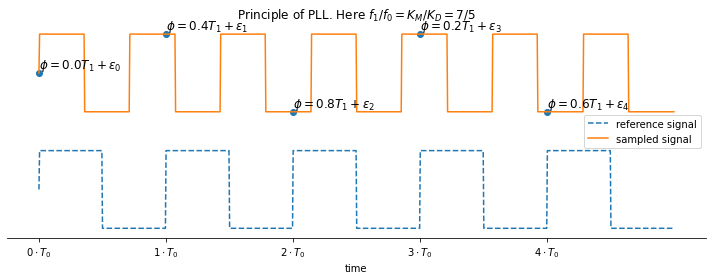

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [10,4]

fig, ax = plt.subplots()
f0 = 5
ts = np.linspace(0,1,1000)
y0= np.sign( np.sin(2*np.pi*f0*ts) )
y0 = -3+y0
ax.plot(ts,y0,linestyle='dashed',label='reference signal')

f1 = 7
y1 = np.sign( np.sin(2*np.pi*f1*ts) )
ax.plot(ts,y1,label='sampled signal')

ts_sampled = np.arange(int(f0))*1/f0
y1_sampled = np.sign( np.sin(2*np.pi*f1*ts_sampled) )
ax.scatter(ts_sampled, y1_sampled)

annotations = ['ble' for _ in ts_sampled]
for i,(text,t,y) in enumerate(zip(annotations,ts_sampled,y1_sampled)):
  phi = np.remainder(t,1/f1)*f1
  phi = phi.round(3)
  ax.text(t,y,f'$\phi={phi} T_1 + \epsilon_{i} $',ha="left", va="bottom",size=12)


ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks([])
ax.set_xticks(ts_sampled)
ax.set_xticklabels([f'${t:.0f}\cdot T_0$' for t in ts_sampled*f0])

ax.legend()
ax.set_title('Principle of PLL. Here $f_1/f_0 = K_M/K_D = 7/5$')# = \frac{7}{5} = \frac{K_M}{K_D}$')
ax.set_xlabel('time')

plt.tight_layout()

The phases of the sampled signal are
$\phi_i = i\cdot \Delta + \epsilon_i \mod T_1 $ where $\Delta = T_1/K_D$ and $\epsilon_i\sim \mathrm{Norm}(0,\sigma^2)$ is the jitter.

We define the counter
$$
N = \sum_{i=1}^{K_D} \mathbb{1}(\phi_i \in (0,T_1/2) )
$$



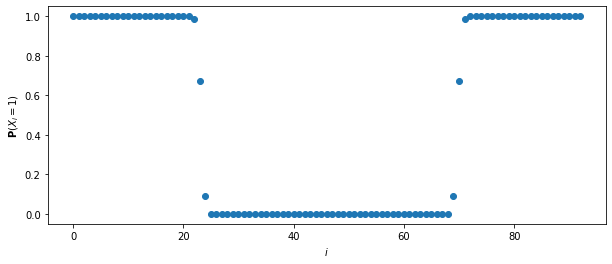

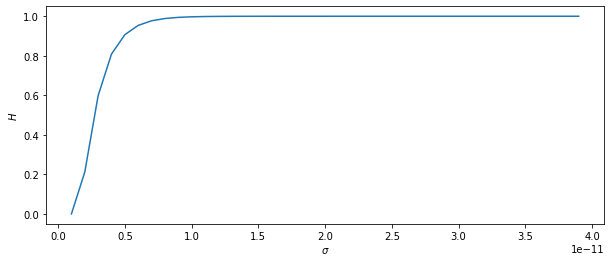

0.5059378032788413 0.9998982659454103


In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from scipy.special import erf

def get_bit_probs_v1(T1,K_D,sigma,phi0_frac):
  """Comuptes probabilities of reordered samples, 
    cf. Eq (4) in "Modern random number generator design – Case study on a secured PLL-based TRNG"""
  i = np.arange(0,K_D) # ordered index from 0 to K_D-1
  Delta = T1/K_D
  phi0 = phi0_frac*T1 # initial_phase
  phi_i = np.remainder(phi0+i*Delta,T1) # signal phases at subsequent samples
  jitter_dist = norm(loc=phi_i,scale=sigma)
  part1 = jitter_dist.cdf(T1/2)-jitter_dist.cdf(0)
  part2 = jitter_dist.cdf(3*T1/2)-jitter_dist.cdf(T1)
  p = part1+part2
  return i,p

def get_bit_probs_v2(T1,K_D,sigma,phi0_frac):
  """Comuptes probabilities of reordered samples, 
    cf. Eq (4) in "Modern random number generator design – Case study on a secured PLL-based TRNG"""
  i = np.arange(0,K_D) # ordered index from 0 to K_D-1
  denom = np.sqrt(2)*sigma/T1
  p = 1- 0.5*erf((i/K_D-phi0_frac)/denom) + 0.5*erf((i/K_D-0.5-phi0_frac)/denom)
  return i,p

get_bit_probs = get_bit_probs_v2

## Test 1: reproduce Fig 7. from "Modern random number generator design – Case study on a secured PLL-based TRNG"

i,ps = get_bit_probs(
  sigma = 9.6*1e-12,
  T1 = 1/( 634.7*1e6 ),
  K_D = 93,
  phi0_frac = 0.25,
)
plt.scatter(i,ps)
plt.xlabel('$i$')
plt.ylabel('$\mathbf{P}(X_i=1)$')
plt.show()

## Test 2: reproduce Fig. 8 (plot 1) from "Modern random number generator design – Case study on a secured PLL-based TRNG"

sigmas = np.arange(1,40)*1e-12
entropy_rates = []
for sigma in sigmas:
  _,ps = get_bit_probs(
    sigma = sigma,
    T1 = 1/( 634.7*1e6 ),
    K_D = 93,
    phi0_frac = 0.25,
  )
  total_p = 1/2+1/2*np.prod(2*ps-1) # as per the formula of Davies
  entropy_rate = entropy([total_p,1-total_p],base=2)
  entropy_rates.append(entropy_rate)

plt.plot(sigmas,entropy_rates)
plt.xlabel('$\sigma$')
plt.ylabel('$H$')
plt.show()

## Test 3: reproduce Tab. 4 (config 1) from "Modern random number generator design – Case study on a secured PLL-based TRNG"

_,ps = get_bit_probs(
  sigma =8.72*1e-12,
  T1 = 1/( 360.1*1e6 ),
  K_D = 279,
  phi0_frac = 0.25, # not sure if we shift the phase?
)

total_p = 1/2+1/2*np.prod(2*ps-1) # as per the formula of Davies
print(total_p,entropy([total_p,1-total_p],base=2))

Artificial reduction!
Reverse the roles of wave and its reference!


* We sample with the reference signal, at frequency $f_0$
* So, rising eges at the sampled signal occur at phases $\phi_i = 
i\cdot T_0 \mod T_1  $
* After rearanging the order, we have $\phi_j = i / K_D \cdot T_1$ where $f_1/f_0 = K_M/K_D$
* In the jitter setup, we assume $\phi_j \sim  i / K_D + \epsilon_j \mod T_1$ where $\epsilon_j \sim N(0,\sigma^2)$
* The bit is one when $\phi_i \in [0,T_1/2]$ and zero otherwise


The equivalent model: the rising edges appear at times $t_i = i\cdot T_0 + \epsilon_i$, we emit $b_i=1$ when
$t_i \mod T_1 < T_1/2$ and $b_i=0$ otherwise.

Then we can apply Schindler's Paper!

We have $\Delta t_i  \sim \epsilon_i - \epsilon_{i-1}$ is 2-independent.


How to estimate entropy
$$
\mathbf{H}(Y_n | Y_{1},\ldots,Y_{n}) \geqslant \mathbf{H}(Y_n | R_{n-1})
$$

so 
$$
\sum_i \mathbf{1}_{0,T/2}(t_i \mod T)
$$







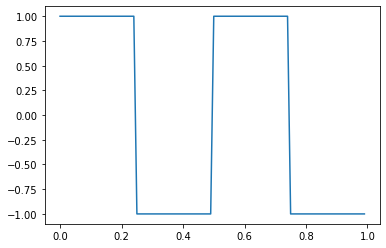

In [ ]:
#from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
ts = np.linspace(0, 1, 100, endpoint=False)
wave = signal.square(2*np.pi*ts*2)
plt.plot(ts, wave)

## Correlations

Index i of random bits in time domain:
[113 118 123 128 230 235 240 245]
Correponding position j(i) of random bits:
[ 77  76  75  74 203 202 201 200]
Ordered position j(i) of random bits:
[ 74  75  76  77 200 201 202 203]


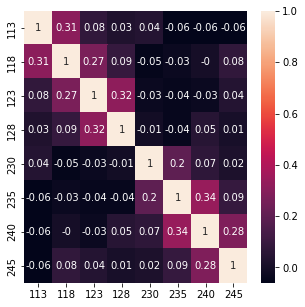

[[ 1.    0.31  0.08  0.03  0.04 -0.06 -0.06 -0.06]
 [ 0.31  1.    0.27  0.09 -0.05 -0.03 -0.    0.08]
 [ 0.08  0.27  1.    0.32 -0.03 -0.04 -0.03  0.04]
 [ 0.03  0.09  0.32  1.   -0.01 -0.04  0.05  0.01]
 [ 0.04 -0.05 -0.03 -0.01  1.    0.2   0.07  0.02]
 [-0.06 -0.03 -0.04 -0.04  0.2   1.    0.34  0.09]
 [-0.06 -0.   -0.03  0.05  0.07  0.34  1.    0.28]
 [-0.06  0.08  0.04  0.01  0.02  0.09  0.28  1.  ]]
Most correlated bits are [235 240]  with correlation 0.34
Index i of random bits in time domain:
[  6  20  34  35  49  63  64  78  92  93 107 121 136 150 165 179 193 194
 208 222]
Correponding position j(i) of random bits:
[ 48 160  41  49 161  42  50 162  43  51 163  44 164  45 165  46 158 166
  47 159]
Ordered position j(i) of random bits:
[ 41  42  43  44  45  46  47  48  49  50  51 158 159 160 161 162 163 164
 165 166]


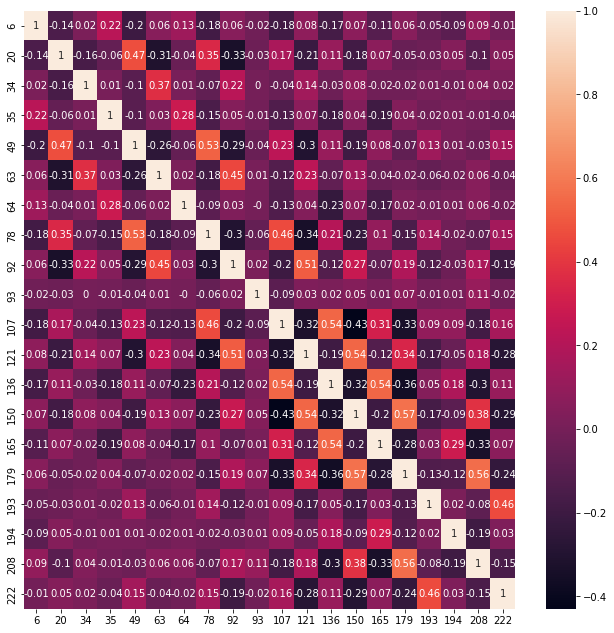

[[ 1.   -0.14  0.02  0.22 -0.2   0.06  0.13 -0.18  0.06 -0.02 -0.18  0.08
  -0.17  0.07 -0.11  0.06 -0.05 -0.09  0.09 -0.01]
 [-0.14  1.   -0.16 -0.06  0.47 -0.31 -0.04  0.35 -0.33 -0.03  0.17 -0.21
   0.11 -0.18  0.07 -0.05 -0.03  0.05 -0.1   0.05]
 [ 0.02 -0.16  1.    0.01 -0.1   0.37  0.01 -0.07  0.22  0.   -0.04  0.14
  -0.03  0.08 -0.02 -0.02  0.01 -0.01  0.04  0.02]
 [ 0.22 -0.06  0.01  1.   -0.1   0.03  0.28 -0.15  0.05 -0.01 -0.13  0.07
  -0.18  0.04 -0.19  0.04 -0.02  0.01 -0.01 -0.04]
 [-0.2   0.47 -0.1  -0.1   1.   -0.26 -0.06  0.53 -0.29 -0.04  0.23 -0.3
   0.11 -0.19  0.08 -0.07  0.13  0.01 -0.03  0.15]
 [ 0.06 -0.31  0.37  0.03 -0.26  1.    0.02 -0.18  0.45  0.01 -0.12  0.23
  -0.07  0.13 -0.04 -0.02 -0.06 -0.02  0.06 -0.04]
 [ 0.13 -0.04  0.01  0.28 -0.06  0.02  1.   -0.09  0.03 -0.   -0.13  0.04
  -0.23  0.07 -0.17  0.02 -0.01  0.01  0.06 -0.02]
 [-0.18  0.35 -0.07 -0.15  0.53 -0.18 -0.09  1.   -0.3  -0.06  0.46 -0.34
   0.21 -0.23  0.1  -0.15  0.14 -0.02 -0.07  0.15]
 

(13, 15)

In [ ]:
def test_correlation(filename,KM,KD):
  img = read_dff(filename=filename,KD=KD,KM=KM)

  probs = img.mean(0) # (KD,)
  mask = (probs > prob_ts) & (probs < 1-prob_ts) # exclude deterministic samples
  non_trivial_bits = img[:,mask]

  non_trivial_is = np.arange(KD)[mask]
  non_trivial_js =  non_trivial_is * KM % KD
  print('Index i of random bits in time domain:')
  print(non_trivial_is)
  print('Correponding position j(i) of random bits:')
  print(non_trivial_js)
  non_trivial_js.sort()
  print('Ordered position j(i) of random bits:')
  print(non_trivial_js)

  # Adapting the figsize to the dimension of the heatmap
  plt.rcParams['figure.figsize'] = [1+sum(mask)/2,1+sum(mask)/2]

  pearson_corr = np.corrcoef(non_trivial_bits.T).round(2)
  sns.heatmap(
      data=pearson_corr,
      annot=True,
      xticklabels=non_trivial_is,
      yticklabels=non_trivial_is)
  plt.show()
  print(pearson_corr)
  return pearson_corr, non_trivial_is


def find_worst_correlation(corrs, bit_pos):
  # Artificially ignore the diagonal coefficients
  for i in range(len(corrs)):
    corrs[i,i]=0
  
  worst_corr_pos = np.unravel_index(np.argmax(np.abs(corrs), axis=None), corrs.shape)
  worst_corr_bits = bit_pos.take(worst_corr_pos)
  print(f'Most correlated bits are {worst_corr_bits}',
        f' with correlation {corrs[worst_corr_pos]}')
  return worst_corr_pos


# Treshold to exclude "not random enough" bits of interest
# Should be between 0 (exclude none) and 1/2 (exclude all)
prob_ts = 0

filename = '/content/data_CV_c_and_CV_d_dff/CVc1/acq_20221005092918_dff.bin'
KM=448
KD=249
corr_matrix, i_values = test_correlation(filename,KM,KD)
find_worst_correlation(corr_matrix, i_values)

filename = '/content/data_CV_c_and_CV_d_dff/CVd1/acq_20221005094040_dff.bin'
KM = 470
KD = 231
corr_matrix, i_values = test_correlation(filename,KM,KD)
find_worst_correlation(corr_matrix, i_values)

In [ ]:
print(corr_matrix)

[[ 0.   -0.14  0.02  0.22 -0.2   0.06  0.13 -0.18  0.06 -0.02 -0.18  0.08
  -0.17  0.07 -0.11  0.06 -0.05 -0.09  0.09 -0.01]
 [-0.14  0.   -0.16 -0.06  0.47 -0.31 -0.04  0.35 -0.33 -0.03  0.17 -0.21
   0.11 -0.18  0.07 -0.05 -0.03  0.05 -0.1   0.05]
 [ 0.02 -0.16  0.    0.01 -0.1   0.37  0.01 -0.07  0.22  0.   -0.04  0.14
  -0.03  0.08 -0.02 -0.02  0.01 -0.01  0.04  0.02]
 [ 0.22 -0.06  0.01  0.   -0.1   0.03  0.28 -0.15  0.05 -0.01 -0.13  0.07
  -0.18  0.04 -0.19  0.04 -0.02  0.01 -0.01 -0.04]
 [-0.2   0.47 -0.1  -0.1   0.   -0.26 -0.06  0.53 -0.29 -0.04  0.23 -0.3
   0.11 -0.19  0.08 -0.07  0.13  0.01 -0.03  0.15]
 [ 0.06 -0.31  0.37  0.03 -0.26  0.    0.02 -0.18  0.45  0.01 -0.12  0.23
  -0.07  0.13 -0.04 -0.02 -0.06 -0.02  0.06 -0.04]
 [ 0.13 -0.04  0.01  0.28 -0.06  0.02  0.   -0.09  0.03 -0.   -0.13  0.04
  -0.23  0.07 -0.17  0.02 -0.01  0.01  0.06 -0.02]
 [-0.18  0.35 -0.07 -0.15  0.53 -0.18 -0.09  0.   -0.3  -0.06  0.46 -0.34
   0.21 -0.23  0.1  -0.15  0.14 -0.02 -0.07  0.15]
 

### Stationarity/Correlation Experiment

In [ ]:
filename = '/content/data_CV_c_and_CV_d_dff/CVd1/acq_20221005094040_dff.bin'
KM = 470
KD = 231

img = read_dff(filename=filename,KD=KD,KM=KM)
img.shape

(346, 231)

In [ ]:
position_j = 0
bytes_series = img[:,position_j]
results = kpss(bytes_series,nlags=10)
results[1]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

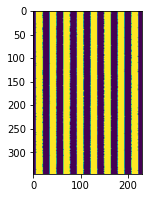

In [ ]:
plt.imshow(img)

For rows $i$ (subsequent $T_Q$ periods), we consider samples $j=0..K_D-1$
$$
X_{i,j}
$$

Then
- Stationarity for $X_{i,\bullet}$ for every $j$-fixed.
- Independentce of $X_{\bullet,j}$ (also used when XORing, Dav02)

give us stationarity of the group of bits $X_{i,\bullet}$





# Analysis of 20221214 data

In [ ]:
!curl -L "https://filesender.renater.fr/download.php?token=cbdefacf-6fb7-4e4c-947a-88f9fa551d50&files_ids=20358641" --output TCHES2023.zip
!mkdir TCHES2023
!unzip -q TCHES2023.zip -d TCHES2023/ # all configs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40.2M  100 40.2M    0     0   771k      0  0:00:53  0:00:53 --:--:--  788k
